# Neural Nets with Keras

In this notebook you will learn how to implement neural networks using the Keras API. We will use TensorFlow's own implementation, *tf.keras*, which comes bundled with TensorFlow.

Don't hesitate to look at the documentation at [keras.io](https://keras.io/). All the code examples should work fine with tf.keras, the only difference is how to import Keras:

```python
# keras.io code:
from keras.layers import Dense
output_layer = Dense(10)

# corresponding tf.keras code:
from tensorflow.keras.layers import Dense
output_layer = Dense(10)

# or:
from tensorflow import keras
output_layer = keras.layers.Dense(10)
```

In this notebook, we will not use any TensorFlow-specific code, so everything you see would run just the same way on [keras-team](https://github.com/keras-team/keras) or any other Python implementation of the Keras API (except for the imports).

## Imports

In [3]:
%matplotlib inline
%load_ext tensorboard

In [4]:
import matplotlib as mpl
import pydot
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sklearn
import sys
import tensorflow as tf
from tensorflow import keras  # tf.keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
import time

In [5]:
from sklearn.preprocessing import StandardScaler

In [4]:
print("python", sys.version)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

python 3.6.9 (default, Oct  8 2020, 12:12:24) 
[GCC 8.4.0]
matplotlib 3.3.0
numpy 1.19.1
pandas 1.0.5
sklearn 0.23.1
tensorflow 2.2.0
tensorflow.keras 2.3.0-tf


In [14]:
assert sys.version_info >= (3, 5) # Python ≥3.5 required
assert tf.__version__ >= "2.0"    # TensorFlow ≥2.0 required

![Exercise](https://c1.staticflickr.com/9/8101/8553474140_c50cf08708_b.jpg)

## Exercise 1 – TensorFlow Playground

Visit the [TensorFlow Playground](http://playground.tensorflow.org).
* **Layers and patterns**: try training the default neural network by clicking the "Run" button (top left). Notice how it quickly finds a good solution for the classification task. Notice that the neurons in the first hidden layer have learned simple patterns, while the neurons in the second hidden layer have learned to combine the simple patterns of the first hidden layer into more complex patterns). In general, the more layers, the more complex the patterns can be.
* **Activation function**: try replacing the Tanh activation function with the ReLU activation function, and train the network again. Notice that it finds a solution even faster, but this time the boundaries are linear. This is due to the shape of the ReLU function.
* **Local minima**: modify the network architecture to have just one hidden layer with three neurons. Train it multiple times (to reset the network weights, just add and remove a neuron). Notice that the training time varies a lot, and sometimes it even gets stuck in a local minimum.
* **Too small**: now remove one neuron to keep just 2. Notice that the neural network is now incapable of finding a good solution, even if you try multiple times. The model has too few parameters and it systematically underfits the training set.
* **Large enough**: next, set the number of neurons to 8 and train the network several times. Notice that it is now consistently fast and never gets stuck. This highlights an important finding in neural network theory: large neural networks almost never get stuck in local minima, and even when they do these local optima are almost as good as the global optimum. However, they can still get stuck on long plateaus for a long time.
* **Deep net and vanishing gradients**: now change the dataset to be the spiral (bottom right dataset under "DATA"). Change the network architecture to have 4 hidden layers with 8 neurons each. Notice that training takes much longer, and often gets stuck on plateaus for long periods of time. Also notice that the neurons in the highest layers (i.e. on the right) tend to evolve faster than the neurons in the lowest layers (i.e. on the left). This problem, called the "vanishing gradients" problem, can be alleviated using better weight initialization and other techniques, better optimizers (such as AdaGrad or Adam), or using Batch Normalization.
* **More**: go ahead and play with the other parameters to get a feel of what they do. In fact, after this course you should definitely play with this UI for at least one hour, it will grow your intuitions about neural networks significantly.

![Exercise](https://c1.staticflickr.com/9/8101/8553474140_c50cf08708_b.jpg)

## Exercise 2 – Image classification with tf.keras

### Load the Fashion MNIST dataset

Let's start by loading the fashion MNIST dataset. Keras has a number of functions to load popular datasets in `keras.datasets`. The dataset is already split for you between a training set and a test set, but it can be useful to split the training set further to have a validation set:

In [5]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = (
    fashion_mnist.load_data())
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

The training set contains 55,000 grayscale images, each 28x28 pixels:

In [7]:
X_train.shape

(55000, 28, 28)

Each pixel intensity is represented by a uint8 (byte) from 0 to 255:

In [7]:
X_train[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   1,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  44, 127,
        182, 185, 161, 120,  55,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,  42, 198, 251, 255,
        251, 249, 247, 255, 252, 214, 100,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   2,   0,   0, 233, 252, 237, 239,
        234, 237, 235, 237, 237, 254, 227,   0,   0,   0,   0,   1,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   2,   0,   0,  16, 210, 225, 215, 175,
        217, 216, 193, 196, 226, 221, 209,  50,   0,   0,   2,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   2,   0,   0, 199, 229, 232, 230, 245, 204,
        219, 253, 245, 207, 194, 223, 231, 236, 235,   0,   0,   3,   0,
          0,   0],
       [  

You can plot an image using Matplotlib's `imshow()` function, with a `'binary'`
 color map:

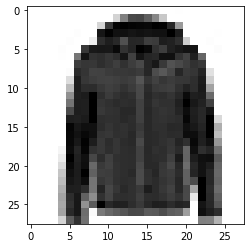

In [10]:
plt.imshow(X_train[0], cmap="binary")
plt.show()

The labels are the class IDs (represented as uint8), from 0 to 9:

In [71]:
y_train

array([4, 0, 7, ..., 3, 0, 5], dtype=uint8)

Here are the corresponding class names:

In [12]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

So the first image in the training set is a coat:

In [13]:
class_names[y_train[0]]

'Coat'

The validation set contains 5,000 images, and the test set contains 10,000 images:

In [14]:
X_valid.shape

(5000, 28, 28)

In [15]:
X_test.shape

(10000, 28, 28)

Let's take a look at a sample of the images in the dataset:

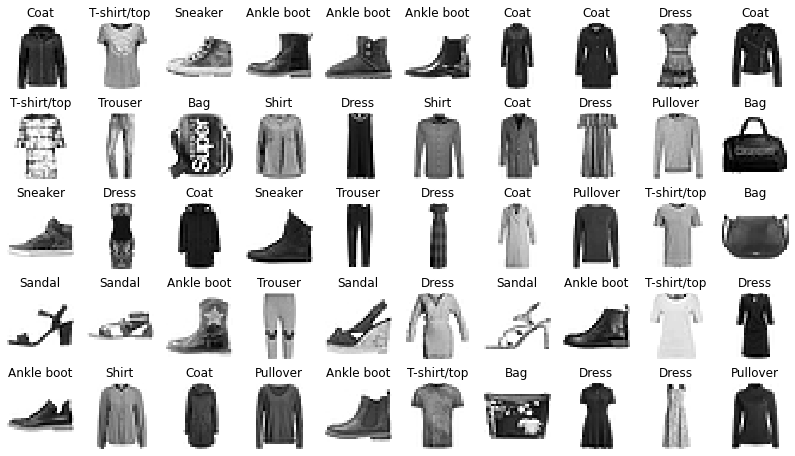

In [16]:
n_rows = 5
n_cols = 10
plt.figure(figsize=(n_cols*1.4, n_rows * 1.6))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]])
plt.show()

This dataset has the same structure as the famous MNIST dataset (which you can load using `keras.datasets.mnist.load_data()`), except the images represent fashion items rather than handwritten digits, and it is much more challenging. A simple linear model can reach 92% accuracy on MNIST, but only 83% on fashion MNIST.

### Build a classification neural network with Keras

### 2.1)
Build a `Sequential` model (`keras.models.Sequential`), without any argument, then and add four layers to it by calling its `add()` method:
  * a `Flatten` layer (`keras.layers.Flatten`) to convert each 28x28 image to a single row of 784 pixel values. Since it is the first layer in your model, you should specify the `input_shape` argument, leaving out the batch size: `[28, 28]`.
  * a `Dense` layer  (`keras.layers.Dense`) with 300 neurons (aka units), and the `"relu"` activation function.
  * Another `Dense` layer with 100 neurons, also with the `"relu"` activation function.
  * A final `Dense` layer with 10 neurons (one per class), and with the `"softmax"` activation function to ensure that the sum of all the estimated class probabilities for each image is equal to 1.

In [17]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28,28]))
model.add(keras.layers.Dense(300, activation="relu"))

In [18]:
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))

### 2.2)
Alternatively, you can pass a list containing the 4 layers to the constructor of the `Sequential` model. The model's `layers` attribute holds the list of layers.

In [81]:
model = keras.models.Sequential(
        [
            layers.Flatten(input_shape=[28,28]),
            layers.Dense(300, activation="relu"),
            layers.Dense(100, activation="relu"),
            layers.Dense(10, activation="softmax")
        ]
)

### 2.3)
Call the model's `summary()` method and examine the output. Also, try using `keras.utils.plot_model()` to save an image of your model's architecture. Alternatively, you can uncomment the following code to display the image within Jupyter.

**Warning**: you will need `pydot` and `graphviz` to use `plot_model()`.

In [82]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 300)               235500    
_________________________________________________________________
dense_13 (Dense)             (None, 100)               30100     
_________________________________________________________________
dense_14 (Dense)             (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


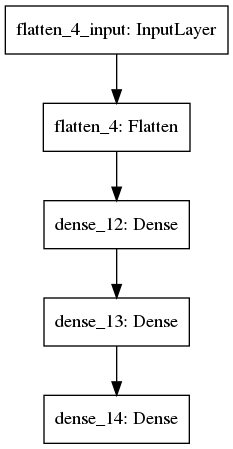

In [84]:
plot_model(model)

### 2.4)
After a model is created, you must call its `compile()` method to specify the `loss` function and the `optimizer` to use. In this case, you want to use the `"sparse_categorical_crossentropy"` loss, and the `keras.optimizers.SGD(lr=1e-3)` optimizer (stochastic gradient descent with a learning rate of 1e-3). Moreover, you can optionally specify a list of additional metrics that should be measured during training. In this case you should specify `metrics=["accuracy"]`. **Note**: you can find more loss functions in `keras.losses`, more metrics in `keras.metrics` and more optimizers in `keras.optimizers`.

In [31]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

### 2.5)
Now your model is ready to be trained. Call its `fit()` method, passing it the input features (`X_train`) and the target classes (`y_train`). Set `epochs=10` (or else it will just run for a single epoch). You can also (optionally) pass the validation data by setting `validation_data=(X_valid, y_valid)`. If you do, Keras will compute the loss and the additional metrics (the accuracy in this case) on the validation set at the end of each epoch. If the performance on the training set is much better than on the validation set, your model is probably overfitting the training set (or there is a bug, such as a mismatch between the training set and the validation set).
**Note**: the `fit()` method will return a `History` object containing training stats. Make sure to preserve it (`history = model.fit(...)`).

In [32]:
history = model.fit(X_train,y_train,
                    epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 7s 4ms/step - loss: 2.2736 - accuracy: 0.7095 - val_loss: 0.6449 - val_accuracy: 0.7772
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5814 - accuracy: 0.7859 - val_loss: 0.5718 - val_accuracy: 0.7950
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4995 - accuracy: 0.8136 - val_loss: 0.5327 - val_accuracy: 0.8192
Epoch 4/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.4563 - accuracy: 0.8299 - val_loss: 0.4859 - val_accuracy: 0.8342
Epoch 5/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4265 - accuracy: 0.8410 - val_loss: 0.4649 - val_accuracy: 0.8386
Epoch 6/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.4048 - accuracy: 0.8485 - val_loss: 0.4579 - val_accuracy: 0.8442
Epoch 7/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.3884 - accuracy: 0.8567 - val_loss: 0.4539 - val_accuracy:

### 2.6)
Try running `pd.DataFrame(history.history).plot()` to plot the learning curves. To make the graph more readable, you can also set `figsize=(8, 5)`, call `plt.grid(True)` and `plt.gca().set_ylim(0, 1)`.

In [18]:
def plot_ler_cur(history):
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid(True)
    plt.gca().set_ylim(0,1)
    plt.show()

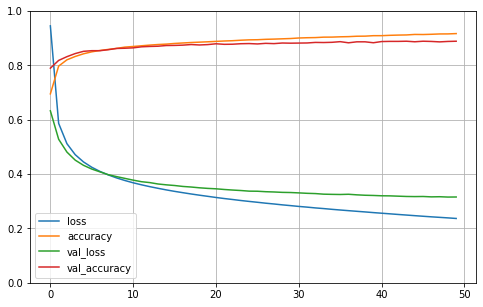

In [17]:
plot_ler_cur(history)

### 2.7)
Try running `model.fit()` again, and notice that training continues where it left off.

In [43]:
history = model.fit(X_train,y_train,
                    epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3426 - accuracy: 0.8710 - val_loss: 0.4292 - val_accuracy: 0.8562
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3346 - accuracy: 0.8753 - val_loss: 0.4265 - val_accuracy: 0.8582
Epoch 3/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3266 - accuracy: 0.8785 - val_loss: 0.4379 - val_accuracy: 0.8584
Epoch 4/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3206 - accuracy: 0.8813 - val_loss: 0.4157 - val_accuracy: 0.8612
Epoch 5/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3147 - accuracy: 0.8825 - val_loss: 0.4253 - val_accuracy: 0.8564
Epoch 6/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3077 - accuracy: 0.8850 - val_loss: 0.4238 - val_accuracy: 0.8590
Epoch 7/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3041 - accuracy: 0.8866 - val_loss: 0.4149 - val_accuracy:

### 2.8)
call the model's `evaluate()` method, passing it the test set (`X_test` and `y_test`). This will compute the loss (cross-entropy) on the test set, as well as all the additional metrics (in this case, the accuracy). Your model should achieve over 80% accuracy on the test set.

In [45]:
model.evaluate(X_test,y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.4289 - accuracy: 0.8528


[0.4288964867591858, 0.8528000116348267]

### 2.9)
Define `X_new` as the first 10 instances of the test set. Call the model's `predict()` method to estimate the probability of each class for each instance (for better readability, you may use the output array's `round()` method):

In [47]:
X_new = X_test[:10]

In [56]:
prob = model.predict(X_new).round(2)

In [57]:
prob

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.98],
       [0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.01, 0.  , 0.01, 0.  , 0.  , 0.  , 0.98, 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.04, 0.  , 0.45, 0.  , 0.52, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  ]],
      dtype=float32)

### 2.10)
Often, you may only be interested in the most likely class. Use `np.argmax()` to get the class ID of the most likely class for each instance. **Tip**: you want to set `axis=1`.

In [59]:
pred = prob.argmax(axis=1)

In [60]:
pred

array([9, 2, 1, 1, 6, 1, 4, 6, 5, 7])

### 2.11)
Call the model's `predict_classes()` method for `X_new`. You should get the same result as above.

In [63]:
pred = model.predict_classes(X_new)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [64]:
pred

array([9, 2, 1, 1, 6, 1, 4, 6, 5, 7])

### 2.12)
(Optional) It is often useful to know how confident the model is for each prediction. Try finding the estimated probability for each predicted class using `np.max()`.

In [66]:
prob.max(axis=1).round(2)

array([0.98, 1.  , 1.  , 1.  , 0.98, 1.  , 1.  , 0.52, 1.  , 1.  ],
      dtype=float32)

### 2.13)
(Optional) It is frequent to want the top k classes and their estimated probabilities rather just the most likely class. You can use `np.argsort()` for this.

In [67]:
prob.argsort()

array([[0, 1, 2, 3, 4, 5, 6, 8, 7, 9],
       [0, 1, 3, 4, 5, 6, 7, 8, 9, 2],
       [0, 2, 3, 4, 5, 6, 7, 8, 9, 1],
       [0, 2, 3, 4, 5, 6, 7, 8, 9, 1],
       [1, 3, 4, 5, 7, 8, 9, 0, 2, 6],
       [0, 2, 3, 4, 5, 6, 7, 8, 9, 1],
       [0, 1, 2, 3, 5, 6, 7, 8, 9, 4],
       [0, 1, 3, 5, 7, 8, 9, 2, 4, 6],
       [0, 1, 2, 3, 4, 6, 7, 8, 9, 5],
       [0, 1, 2, 3, 4, 5, 6, 8, 9, 7]])

![Exercise solution](https://camo.githubusercontent.com/250388fde3fac9135ead9471733ee28e049f7a37/68747470733a2f2f75706c6f61642e77696b696d656469612e6f72672f77696b6970656469612f636f6d6d6f6e732f302f30362f46696c6f735f736567756e646f5f6c6f676f5f253238666c69707065642532392e6a7067)

## Exercise 2 - Solution

### 2.1)
Build a `Sequential` model (`keras.models.Sequential`), without any argument, then and add four layers to it by calling its `add()` method:
  * a `Flatten` layer (`keras.layers.Flatten`) to convert each 28x28 image to a single row of 784 pixel values. Since it is the first layer in your model, you should specify the `input_shape` argument, leaving out the batch size: `[28, 28]`.
  * a `Dense` layer  (`keras.layers.Dense`) with 300 neurons (aka units), and the `"relu"` activation function.
  * Another `Dense` layer with 100 neurons, also with the `"relu"` activation function.
  * A final `Dense` layer with 10 neurons (one per class), and with the `"softmax"` activation function to ensure that the sum of all the estimated class probabilities for each image is equal to 1.

In [5]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))

### 2.2)
Alternatively, you can pass a list containing the 4 layers to the constructor of the `Sequential` model. The model's `layers` attribute holds the list of layers.

In [6]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [7]:
model.layers

### 2.3)
Call the model's `summary()` method and examine the output. Also, try using `keras.utils.plot_model()` to save an image of your model's architecture. Alternatively, you can uncomment the following code to display the image within Jupyter.

In [95]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 300)               235500    
_________________________________________________________________
dense_19 (Dense)             (None, 100)               30100     
_________________________________________________________________
dense_20 (Dense)             (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


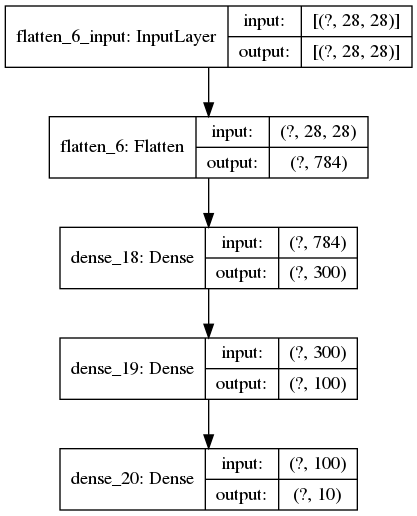

In [96]:
keras.utils.plot_model(model, "my_mnist_model.png", show_shapes=True)

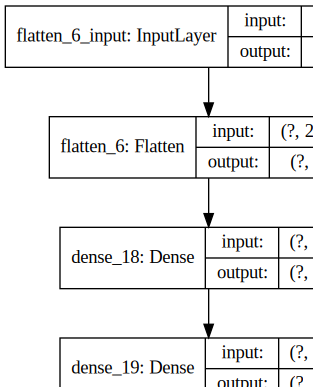

In [97]:
from IPython.display import SVG
SVG(keras.utils.model_to_dot(model, show_shapes=True).create(prog="dot", format="svg"))

### 2.4)
After a model is created, you must call its `compile()` method to specify the `loss` function and the `optimizer` to use. In this case, you want to use the `"sparse_categorical_crossentropy"` loss, and the `keras.optimizers.SGD(lr=1e-3)` optimizer (stochastic gradient descent with learning rate of 1e-3). Moreover, you can optionally specify a list of additional metrics that should be measured during training. In this case you should specify `metrics=["accuracy"]`. **Note**: you can find more loss functions in `keras.losses`, more metrics in `keras.metrics` and more optimizers in `keras.optimizers`.

In [8]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

### 2.5)
Now your model is ready to be trained. Call its `fit()` method, passing it the input features (`X_train`) and the target classes (`y_train`). Set `epochs=10` (or else it will just run for a single epoch). You can also (optionally) pass the validation data by setting `validation_data=(X_valid, y_valid)`. If you do, Keras will compute the loss and the additional metrics (the accuracy in this case) on the validation set at the end of each epoch. If the performance on the training set is much better than on the validation set, your model is probably overfitting the training set (or there is a bug, such as a mismatch between the training set and the validation set).
**Note**: the `fit()` method will return a `History` object containing training stats. Make sure to preserve it (`history = model.fit(...)`).

In [99]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 7s 4ms/step - loss: 2.5141 - accuracy: 0.7285 - val_loss: 0.5797 - val_accuracy: 0.7998
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5380 - accuracy: 0.8053 - val_loss: 0.5117 - val_accuracy: 0.8222
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4785 - accuracy: 0.8241 - val_loss: 0.4901 - val_accuracy: 0.8240
Epoch 4/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4455 - accuracy: 0.8371 - val_loss: 0.4777 - val_accuracy: 0.8342
Epoch 5/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4235 - accuracy: 0.8443 - val_loss: 0.4557 - val_accuracy: 0.8422
Epoch 6/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4060 - accuracy: 0.8497 - val_loss: 0.4514 - val_accuracy: 0.8424
Epoch 7/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3925 - accuracy: 0.8542 - val_loss: 0.4461 - val_accuracy:

### 2.6)
Try running `pd.DataFrame(history.history).plot()` to plot the learning curves. To make the graph more readable, you can also set `figsize=(8, 5)`, call `plt.grid(True)` and `plt.gca().set_ylim(0, 1)`.

In [45]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()

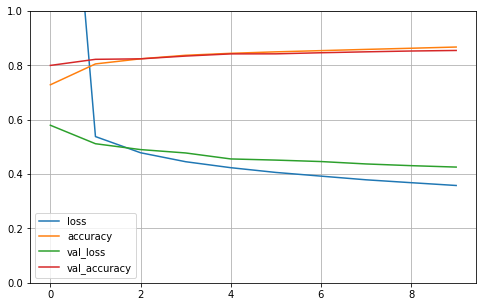

In [101]:
plot_learning_curves(history)

### 2.7)
Try running `model.fit()` again, and notice that training continues where it left off.

In [102]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3497 - accuracy: 0.8699 - val_loss: 0.4243 - val_accuracy: 0.8564
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3422 - accuracy: 0.8729 - val_loss: 0.4232 - val_accuracy: 0.8566
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3342 - accuracy: 0.8754 - val_loss: 0.4332 - val_accuracy: 0.8550
Epoch 4/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3292 - accuracy: 0.8782 - val_loss: 0.4140 - val_accuracy: 0.8564
Epoch 5/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3216 - accuracy: 0.8803 - val_loss: 0.4274 - val_accuracy: 0.8572
Epoch 6/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3177 - accuracy: 0.8819 - val_loss: 0.4321 - val_accuracy: 0.8528
Epoch 7/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.3132 - accuracy: 0.8838 - val_loss: 0.4328 - val_accuracy:

### 2.8)
Call the model's `evaluate()` method, passing it the test set (`X_test` and `y_test`). This will compute the loss (cross-entropy) on the test set, as well as all the additional metrics (in this case, the accuracy). Your model should achieve over 80% accuracy on the test set.

In [103]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.4568 - accuracy: 0.8491


[0.45675045251846313, 0.8490999937057495]

### 2.9)
Define `X_new` as the first 10 instances of the test set. Call the model's `predict()` method to estimate the probability of each class for each instance (for better readability, you may use the output array's `round()` method):

In [104]:
n_new = 10
X_new = X_test[:n_new]
y_proba = model.predict(X_new)
y_proba.round(2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.04, 0.  , 0.96],
       [0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.36, 0.  , 0.09, 0.01, 0.01, 0.  , 0.53, 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.11, 0.  , 0.74, 0.  , 0.12, 0.  , 0.02, 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.99, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  ]],
      dtype=float32)

### 2.10)
Often, you may only be interested in the most likely class. Use `np.argmax()` to get the class ID of the most likely class for each instance. **Tip**: you want to set `axis=1`.

In [105]:
y_pred = y_proba.argmax(axis=1)
y_pred

array([9, 2, 1, 1, 6, 1, 4, 6, 5, 7])

### 2.11)
Call the model's `predict_classes()` method for `X_new`. You should get the same result as above.

In [106]:
y_pred = model.predict_classes(X_new)
y_pred

array([9, 2, 1, 1, 6, 1, 4, 6, 5, 7])

### 2.12)
(Optional) It is often useful to know how confident the model is for each prediction. Try finding the estimated probability for each predicted class using `np.max()`.

In [107]:
y_proba.max(axis=1).round(2)

array([0.96, 1.  , 1.  , 1.  , 0.53, 1.  , 0.74, 0.99, 1.  , 1.  ],
      dtype=float32)

### 2.13)
(Optional) It is frequent to want the top k classes and their estimated probabilities rather just the most likely class. You can use `np.argsort()` for this.

In [108]:
k = 3
top_k = np.argsort(-y_proba, axis=1)[:, :k]
top_k

array([[9, 7, 5],
       [2, 4, 6],
       [1, 0, 4],
       [1, 0, 3],
       [6, 0, 2],
       [1, 0, 4],
       [4, 6, 2],
       [6, 4, 2],
       [5, 7, 3],
       [7, 5, 8]])

In [109]:
row_indices = np.tile(np.arange(len(top_k)), [k, 1]).T
y_proba[row_indices, top_k].round(2)

array([[0.96, 0.04, 0.  ],
       [1.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  ],
       [0.53, 0.36, 0.09],
       [1.  , 0.  , 0.  ],
       [0.74, 0.12, 0.11],
       [0.99, 0.01, 0.  ],
       [1.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  ]], dtype=float32)

![Exercise](https://c1.staticflickr.com/9/8101/8553474140_c50cf08708_b.jpg)

## Exercise 3 – Scale the features

# 3.1)
When using Gradient Descent, it is usually best to ensure that the features all have a similar scale, preferably with a Normal distribution. Try to standardize the pixel values and see if this improves the performance of your neural network.

**Tips**:
* For each feature (pixel intensity), you must subtract the `mean()` of that feature (across all instances, so use `axis=0`) and divide by its standard deviation (`std()`, again `axis=0`). Alternatively, you can use Scikit-Learn's `StandardScaler`.
* Make sure you compute the means and standard deviations on the training set, and use these statistics to scale the training set, the validation set and the test set (you should not fit the validation set or the test set, and computing the means and standard deviations counts as "fitting").

In [141]:
scaler = StandardScaler()

In [146]:
scaled_X_train = (scaler.fit_transform(X_train.reshape(-1, 28*28))).reshape(-1,28,28)
scaled_X_valid = (scaler.transform(X_valid.reshape(-1, 28*28))).reshape(-1,28,28)
scaled_X_test = (scaler.transform(X_test.reshape(-1, 28*28))).reshape(-1,28,28)

In [147]:
history = model.fit(scaled_X_train, y_train, epochs=10,
                    validation_data=(scaled_X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.9730 - accuracy: 0.6845 - val_loss: 0.6423 - val_accuracy: 0.7780
Epoch 2/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.5969 - accuracy: 0.7909 - val_loss: 0.5337 - val_accuracy: 0.8170
Epoch 3/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.5198 - accuracy: 0.8169 - val_loss: 0.4881 - val_accuracy: 0.8328
Epoch 4/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.4789 - accuracy: 0.8298 - val_loss: 0.4614 - val_accuracy: 0.8408
Epoch 5/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.4519 - accuracy: 0.8393 - val_loss: 0.4416 - val_accuracy: 0.8464
Epoch 6/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.4319 - accuracy: 0.8466 - val_loss: 0.4269 - val_accuracy: 0.8532
Epoch 7/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.4161 - accuracy: 0.8518 - val_loss: 0.4159 - val_accuracy:

In [151]:
model.evaluate(scaled_X_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.4259 - accuracy: 0.8452


[0.4259132742881775, 0.8452000021934509]

### 3.2)
Plot the learning curves. Do they look better than earlier?

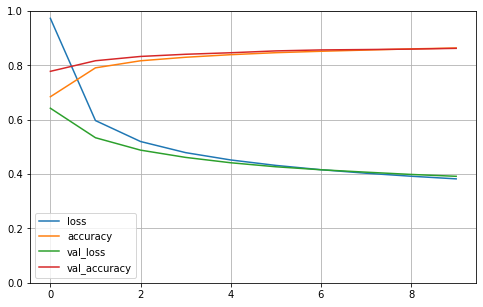

In [149]:
plot_learning_curves(history)

![Exercise solution](https://camo.githubusercontent.com/250388fde3fac9135ead9471733ee28e049f7a37/68747470733a2f2f75706c6f61642e77696b696d656469612e6f72672f77696b6970656469612f636f6d6d6f6e732f302f30362f46696c6f735f736567756e646f5f6c6f676f5f253238666c69707065642532392e6a7067)

## Exercise 3 – Solution

### 3.1)
When using Gradient Descent, it is usually best to ensure that the features all have a similar scale, preferably with a Normal distribution. Try to standardize the pixel values and see if this improves the performance of your neural network.

In [152]:
pixel_means = X_train.mean(axis = 0)
pixel_stds = X_train.std(axis = 0)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [9]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float32).reshape(-1, 28 * 28)).reshape(-1, 28, 28)
X_valid_scaled = scaler.transform(X_valid.astype(np.float32).reshape(-1, 28 * 28)).reshape(-1, 28, 28)
X_test_scaled = scaler.transform(X_test.astype(np.float32).reshape(-1, 28 * 28)).reshape(-1, 28, 28)

In [154]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(1e-3), metrics=["accuracy"])
history = model.fit(X_train_scaled, y_train, epochs=20,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/20
1719/1719 [==============================] - 9s 5ms/step - loss: 0.9351 - accuracy: 0.6951 - val_loss: 0.6331 - val_accuracy: 0.7878
Epoch 2/20
1719/1719 [==============================] - 8s 5ms/step - loss: 0.5825 - accuracy: 0.7997 - val_loss: 0.5300 - val_accuracy: 0.8178
Epoch 3/20
1719/1719 [==============================] - 9s 5ms/step - loss: 0.5066 - accuracy: 0.8220 - val_loss: 0.4826 - val_accuracy: 0.8334
Epoch 4/20
1719/1719 [==============================] - 8s 5ms/step - loss: 0.4662 - accuracy: 0.8351 - val_loss: 0.4524 - val_accuracy: 0.8468
Epoch 5/20
1719/1719 [==============================] - 8s 5ms/step - loss: 0.4398 - accuracy: 0.8442 - val_loss: 0.4326 - val_accuracy: 0.8520
Epoch 6/20
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4207 - accuracy: 0.8508 - val_loss: 0.4183 - val_accuracy: 0.8578
Epoch 7/20
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4057 - accuracy: 0.8559 - val_loss: 0.4073 - val_accuracy

In [155]:
model.evaluate(X_test_scaled, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.3819 - accuracy: 0.8619


[0.38188016414642334, 0.8618999719619751]

### 3.2)
Plot the learning curves. Do they look better than earlier?

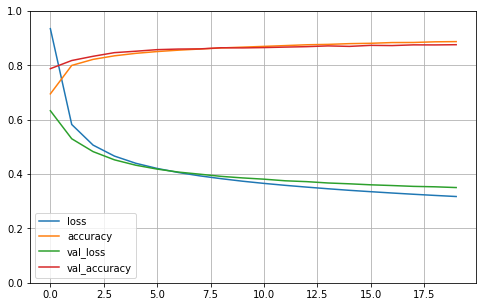

In [156]:
plot_learning_curves(history)

![Exercise](https://c1.staticflickr.com/9/8101/8553474140_c50cf08708_b.jpg)

## Exercise 4 – Use Callbacks

### 4.1)
The `fit()` method accepts a `callbacks` argument. Try training your model with a large number of epochs, a validation set, and with a few callbacks from `keras.callbacks`:
* `TensorBoard`: specify a log directory. It should be a subdirectory of a root logdir, such as `./my_logs/run_1`, and it should be different every time you train your model. You can use a timestamp in the subdirectory's path to ensure that it changes at every run.
* `EarlyStopping`: specify `patience=5`
* `ModelCheckpoint`: specify the path of the checkpoint file to save (e.g., `"my_mnist_model.h5"`) and set `save_best_only=True`

Notice that the `EarlyStopping` callback will interrupt training before it reaches the requested number of epochs. This reduces the risk of overfitting.

In [158]:
logdir = os.path.join(os.curdir, "logs")
callbacks = [
    keras.callbacks.TensorBoard(logdir),
    keras.callbacks.EarlyStopping(patience=5),
    keras.callbacks.ModelCheckpoint("mnist_model.h5", save_best_only=True),
]

In [161]:
history = model.fit(X_train_scaled, y_train, epochs=20,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=callbacks)

Epoch 1/20
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3133 - accuracy: 0.8891 - val_loss: 0.3496 - val_accuracy: 0.8758
Epoch 2/20
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3093 - accuracy: 0.8904 - val_loss: 0.3459 - val_accuracy: 0.8780
Epoch 3/20
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3060 - accuracy: 0.8917 - val_loss: 0.3437 - val_accuracy: 0.8790
Epoch 4/20
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3026 - accuracy: 0.8927 - val_loss: 0.3424 - val_accuracy: 0.8790
Epoch 5/20
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2991 - accuracy: 0.8945 - val_loss: 0.3404 - val_accuracy: 0.8814
Epoch 6/20
1719/1719 [==============================] - 11s 6ms/step - loss: 0.2959 - accuracy: 0.8953 - val_loss: 0.3394 - val_accuracy: 0.8806
Epoch 7/20
1719/1719 [==============================] - 16s 9ms/step - loss: 0.2927 - accuracy: 0.8967 - val_loss: 0.3386 - val_accurac

In [12]:
root_logdir = os.path.join(os.curdir, "logs")

### 4.2)
The Jupyter plugin for tensorboard was loaded at the beginning of this notebook (`%load_ext tensorboard`), so you can now simply start it by using the `%tensorboard` magic command. Explore the various tabs available, in particular the SCALARS tab to view learning curves, the GRAPHS tab to view the computation graph, and the PROFILE tab which is very useful to identify bottlenecks if you run into performance issues.

In [21]:
%tensorboard --logdir=./logs

### 4.3)
The early stopping callback only stopped training after 10 epochs without progress, so your model may already have started to overfit the training set. Fortunately, since the `ModelCheckpoint` callback only saved the best models (on the validation set), the last saved model is the best on the validation set, so try loading it using `keras.models.load_model()`. Finally evaluate it on the test set.

In [165]:
model = keras.models.load_model("mnist_model.h5")

In [166]:
model.evaluate(X_test_scaled, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.3534 - accuracy: 0.8731


[0.3533753454685211, 0.8730999827384949]

### 4.4)
Look at the list of available callbacks at https://keras.io/callbacks/

![Exercise solution](https://camo.githubusercontent.com/250388fde3fac9135ead9471733ee28e049f7a37/68747470733a2f2f75706c6f61642e77696b696d656469612e6f72672f77696b6970656469612f636f6d6d6f6e732f302f30362f46696c6f735f736567756e646f5f6c6f676f5f253238666c69707065642532392e6a7067)

## Exercise 4 – Solution

### 4.1)
The `fit()` method accepts a `callbacks` argument. Try training your model with a large number of epochs, a validation set, and with a few callbacks from `keras.callbacks`:
* `TensorBoard`: specify a log directory. It should be a subdirectory of a root logdir, such as `./my_logs/run_1`, and it should be different every time you train your model. You can use a timestamp in the subdirectory's path to ensure that it changes at every run.
* `EarlyStopping`: specify `patience=5`
* `ModelCheckpoint`: specify the path of the checkpoint file to save (e.g., `"my_mnist_model.h5"`) and set `save_best_only=True`

Notice that the `EarlyStopping` callback will interrupt training before it reaches the requested number of epochs. This reduces the risk of overfitting.

In [10]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(1e-3), metrics=["accuracy"])

In [13]:
logdir = os.path.join(root_logdir, "run_{}".format(time.time()))

callbacks = [
    keras.callbacks.TensorBoard(logdir),
    keras.callbacks.EarlyStopping(patience=3),
    keras.callbacks.ModelCheckpoint("my_mnist_model.h5", save_best_only=True),
]
history = model.fit(X_train_scaled, y_train, epochs=50,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=callbacks)

Epoch 1/50
1719/1719 [==============================] - 8s 5ms/step - loss: 0.9454 - accuracy: 0.6951 - val_loss: 0.6329 - val_accuracy: 0.7896
Epoch 2/50
1719/1719 [==============================] - 8s 5ms/step - loss: 0.5866 - accuracy: 0.7973 - val_loss: 0.5281 - val_accuracy: 0.8182
Epoch 3/50
1719/1719 [==============================] - 8s 5ms/step - loss: 0.5118 - accuracy: 0.8204 - val_loss: 0.4809 - val_accuracy: 0.8320
Epoch 4/50
1719/1719 [==============================] - 8s 5ms/step - loss: 0.4714 - accuracy: 0.8327 - val_loss: 0.4513 - val_accuracy: 0.8434
Epoch 5/50
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4447 - accuracy: 0.8425 - val_loss: 0.4323 - val_accuracy: 0.8516
Epoch 6/50
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4251 - accuracy: 0.8498 - val_loss: 0.4185 - val_accuracy: 0.8540
Epoch 7/50
1719/1719 [==============================] - 8s 5ms/step - loss: 0.4096 - accuracy: 0.8547 - val_loss: 0.4080 - val_accuracy:

### 4.2)
Done

### 4.3)
The early stopping callback only stopped training after 10 epochs without progress, so your model may already have started to overfit the training set. Fortunately, since the `ModelCheckpoint` callback only saved the best models (on the validation set), the last saved model is the best on the validation set, so try loading it using `keras.models.load_model()`. Finally evaluate it on the test set.

In [14]:
model = keras.models.load_model("my_mnist_model.h5")

In [15]:
model.evaluate(X_valid_scaled, y_valid)

157/157 [==============================] - 0s 3ms/step - loss: 0.3154 - accuracy: 0.8880


[0.3154468536376953, 0.8880000114440918]

### 4.4)
Look at the list of available callbacks at https://keras.io/callbacks/

![Exercise](https://c1.staticflickr.com/9/8101/8553474140_c50cf08708_b.jpg)

## Exercise 5 – A neural net for regression

### 5.1)
Load the California housing dataset using `sklearn.datasets.fetch_california_housing`. This returns an object with a `DESCR` attribute describing the dataset, a `data` attribute with the input features, and a `target` attribute with the labels. The goal is to predict the price of houses in a district (a census block) given some stats about that district. This is a regression task (predicting values).

In [16]:
from sklearn import datasets

In [17]:
cali_hos = datasets.fetch_california_housing()

In [18]:
X = pd.DataFrame(cali_hos.data, columns=cali_hos.feature_names)
y = cali_hos.target

In [19]:
X

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25
...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32


### 5.2)
Split the dataset into a training set, a validation set and a test set using Scikit-Learn's `sklearn.model_selection.train_test_split()` function.

In [20]:
from sklearn.model_selection import train_test_split

In [21]:
 X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

 X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

In [22]:
y_train

array([2.281, 0.55 , 1.745, ..., 2.14 , 0.591, 1.951])

### 5.3)
Scale the input features (e.g., using a `sklearn.preprocessing.StandardScaler`). Once again, don't forget that you should not fit the validation set or the test set, only the training set.

In [23]:
scaler = StandardScaler()

In [24]:
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_val = scaler.transform(X_val)
scaled_X_test = scaler.transform(X_test)

### 5.4)
Now build, train and evaluate a neural network to tackle this problem. Then use it to make predictions on the test set.

**Tips**:
* Since you are predicting a single value per district (the median house price), there should only be one neuron in the output layer.
* Usually for regression tasks you don't want to use any activation function in the output layer (in some cases you may want to use `"relu"` or `"softplus"` if you want to constrain the predicted values to be positive, or `"sigmoid"` or `"tanh"` if you want to constrain the predicted values to 0-1 or -1-1).
* A good loss function for regression is generally the `"mean_squared_error"` (aka `"mse"`). When there are many outliers in your dataset, you may prefer to use the `"mean_absolute_error"` (aka `"mae"`), which is a bit less precise but less sensitive to outliers.

In [25]:
input_shape=X_train.shape[1:]
input_shape

(8,)

In [26]:
logdir = os.path.join(os.curdir, "logs")

In [27]:
callbacks = [
    keras.callbacks.TensorBoard(logdir),
    keras.callbacks.EarlyStopping(patience=5),
    keras.callbacks.ModelCheckpoint("housing_model.h5", save_best_only=True),
]
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])
model.compile(loss="mean_squared_error",
              optimizer=keras.optimizers.SGD(1e-3), metrics=["accuracy"])

In [28]:
history = model.fit(scaled_X_train, y_train, epochs=50,
                    validation_data=(scaled_X_val, y_val),
                    callbacks=callbacks)

Epoch 1/50
387/387 [==============================] - 1s 4ms/step - loss: 1.7388 - accuracy: 0.0026 - val_loss: 0.7793 - val_accuracy: 0.0027
Epoch 2/50
387/387 [==============================] - 1s 3ms/step - loss: 0.7643 - accuracy: 0.0032 - val_loss: 0.7047 - val_accuracy: 0.0027
Epoch 3/50
387/387 [==============================] - 1s 3ms/step - loss: 0.7092 - accuracy: 0.0032 - val_loss: 0.6671 - val_accuracy: 0.0027
Epoch 4/50
387/387 [==============================] - 1s 3ms/step - loss: 0.6751 - accuracy: 0.0032 - val_loss: 0.6377 - val_accuracy: 0.0027
Epoch 5/50
387/387 [==============================] - 1s 3ms/step - loss: 0.6475 - accuracy: 0.0032 - val_loss: 0.6134 - val_accuracy: 0.0027
Epoch 6/50
387/387 [==============================] - 1s 3ms/step - loss: 0.6246 - accuracy: 0.0032 - val_loss: 0.5926 - val_accuracy: 0.0027
Epoch 7/50
387/387 [==============================] - 1s 3ms/step - loss: 0.6059 - accuracy: 0.0032 - val_loss: 0.5741 - val_accuracy: 0.0027
Epoch 

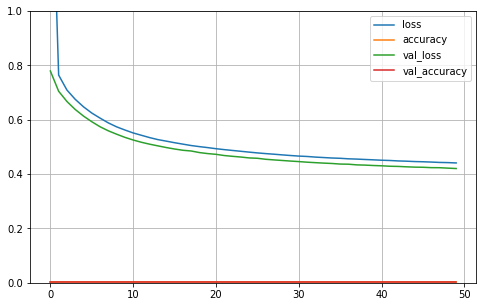

In [32]:
plot_ler_cur(history)

In [33]:
%tensorboard --logdir=./logs

In [34]:
model.evaluate(scaled_X_val, y_val)

129/129 [==============================] - 0s 1ms/step - loss: 0.4204 - accuracy: 0.0027


[0.42044079303741455, 0.0026647287886589766]

![Exercise solution](https://camo.githubusercontent.com/250388fde3fac9135ead9471733ee28e049f7a37/68747470733a2f2f75706c6f61642e77696b696d656469612e6f72672f77696b6970656469612f636f6d6d6f6e732f302f30362f46696c6f735f736567756e646f5f6c6f676f5f253238666c69707065642532392e6a7067)

## Exercise 5 – Solution

### 5.1)
Load the California housing dataset using `sklearn.datasets.fetch_california_housing`. This returns an object with a `DESCR` attribute describing the dataset, a `data` attribute with the input features, and a `target` attribute with the labels. The goal is to predict the price of houses in a district (a census block) given some stats about that district. This is a regression task (predicting values).

In [5]:
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing()

In [6]:
print(housing.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

In [7]:
housing.data.shape

(20640, 8)

In [8]:
housing.target.shape

(20640,)

### 5.2)
Split the dataset into a training set, a validation set and a test set using Scikit-Learn's `sklearn.model_selection.train_test_split()` function.

In [9]:
from sklearn.model_selection import train_test_split

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

In [10]:
len(X_train), len(X_valid), len(X_test)

(11610, 3870, 5160)

### 5.3)
Scale the input features (e.g., using a `sklearn.preprocessing.StandardScaler`). Once again, don't forget that you should not fit the validation set or the test set, only the training set.

In [11]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

### 5.4)
Now build, train and evaluate a neural network to tackle this problem. Then use it to make predictions on the test set.

In [42]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(1e-3))

In [43]:
callbacks = [keras.callbacks.EarlyStopping(patience=10)]
history = model.fit(X_train_scaled, y_train,
                    validation_data=(X_valid_scaled, y_valid), epochs=100,
                    callbacks=callbacks)

Epoch 1/100
363/363 [==============================] - 1s 3ms/step - loss: 2.0364 - val_loss: 2.2106
Epoch 2/100
363/363 [==============================] - 1s 2ms/step - loss: 0.8680 - val_loss: 0.8439
Epoch 3/100
363/363 [==============================] - 1s 2ms/step - loss: 0.7295 - val_loss: 0.6560
Epoch 4/100
363/363 [==============================] - 1s 2ms/step - loss: 0.6687 - val_loss: 0.6408
Epoch 5/100
363/363 [==============================] - 1s 2ms/step - loss: 0.6280 - val_loss: 0.6189
Epoch 6/100
363/363 [==============================] - 1s 2ms/step - loss: 0.5958 - val_loss: 0.5542
Epoch 7/100
363/363 [==============================] - 1s 2ms/step - loss: 0.5678 - val_loss: 0.5580
Epoch 8/100
363/363 [==============================] - 1s 3ms/step - loss: 0.5441 - val_loss: 0.5102
Epoch 9/100
363/363 [==============================] - 1s 2ms/step - loss: 0.5235 - val_loss: 0.4944
Epoch 10/100
363/363 [==============================] - 1s 2ms/step - loss: 0.5057 - val_lo

In [44]:
model.evaluate(X_test_scaled, y_test)

162/162 [==============================] - 0s 1ms/step - loss: 0.3660


0.36595284938812256

In [45]:
model.predict(X_test_scaled)

array([[0.6064484],
       [1.722511 ],
       [3.6107512],
       ...,
       [1.2809523],
       [2.4896803],
       [3.931334 ]], dtype=float32)

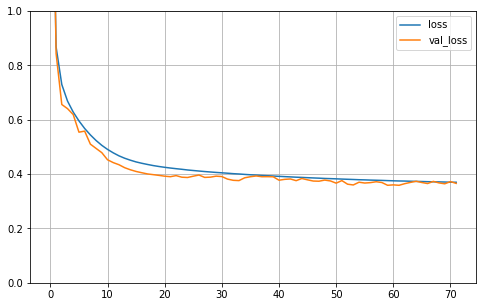

In [46]:
plot_ler_cur(history)

![Exercise](https://c1.staticflickr.com/9/8101/8553474140_c50cf08708_b.jpg)

## Exercise 6 – Hyperparameter search

### 6.1)
Try training your model multiple times, with different a learning rate each time (e.g., 1e-4, 3e-4, 1e-3, 3e-3, 3e-2), and compare the learning curves. For this, you need to create a `keras.optimizers.SGD` optimizer and specify the `learning_rate` in its constructor, then pass this `SGD` instance to the `compile()` method using the `optimizer` argument.

In [50]:
lr_rate = [1e-4, 3e-4, 1e-3, 3e-3, 3e-2]

In [51]:
histories = []
for lr in lr_rate:
    model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
    ])
    
    lr_r = lr
    model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(lr_r))
    
    callbacks = [keras.callbacks.EarlyStopping(patience=10)]
    
    history = model.fit(X_train_scaled, y_train,
                    validation_data=(X_valid_scaled, y_valid), epochs=100,
                    callbacks=callbacks)
    histories.append(history)

Epoch 1/100
363/363 [==============================] - 1s 3ms/step - loss: 5.7068 - val_loss: 6.6781
Epoch 2/100
363/363 [==============================] - 1s 3ms/step - loss: 4.0397 - val_loss: 3.9469
Epoch 3/100
363/363 [==============================] - 1s 3ms/step - loss: 3.0252 - val_loss: 2.6402
Epoch 4/100
363/363 [==============================] - 1s 2ms/step - loss: 2.3714 - val_loss: 2.0177
Epoch 5/100
363/363 [==============================] - 1s 2ms/step - loss: 1.9321 - val_loss: 1.6947
Epoch 6/100
363/363 [==============================] - 1s 2ms/step - loss: 1.6259 - val_loss: 1.5113
Epoch 7/100
363/363 [==============================] - 1s 2ms/step - loss: 1.4064 - val_loss: 1.3824
Epoch 8/100
363/363 [==============================] - 1s 2ms/step - loss: 1.2455 - val_loss: 1.2809
Epoch 9/100
363/363 [==============================] - 1s 2ms/step - loss: 1.1251 - val_loss: 1.1905
Epoch 10/100
363/363 [==============================] - 1s 2ms/step - loss: 1.0335 - val_lo

363/363 [==============================] - 1s 2ms/step - loss: 0.4514 - val_loss: 0.4212
Epoch 62/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4497 - val_loss: 0.4196
Epoch 63/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4482 - val_loss: 0.4184
Epoch 64/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4467 - val_loss: 0.4171
Epoch 65/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4452 - val_loss: 0.4158
Epoch 66/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4438 - val_loss: 0.4147
Epoch 67/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4425 - val_loss: 0.4138
Epoch 68/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4412 - val_loss: 0.4132
Epoch 69/100
363/363 [==============================] - 1s 3ms/step - loss: 0.4400 - val_loss: 0.4122
Epoch 70/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4388 - val_loss: 

363/363 [==============================] - 1s 2ms/step - loss: 0.3456 - val_loss: 0.3372
Epoch 69/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3449 - val_loss: 0.4770
Epoch 70/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3448 - val_loss: 0.3256
Epoch 71/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3438 - val_loss: 0.3538
Epoch 72/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3431 - val_loss: 0.3327
Epoch 73/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3424 - val_loss: 0.3245
Epoch 74/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3425 - val_loss: 0.3293
Epoch 75/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3414 - val_loss: 0.3947
Epoch 76/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3420 - val_loss: 0.3364
Epoch 77/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3407 - val_loss: 

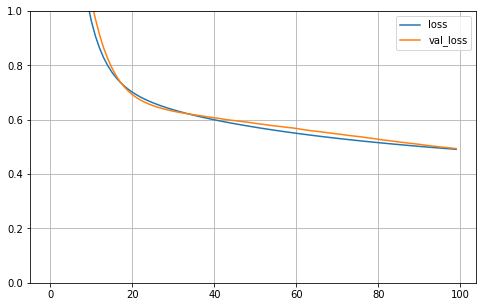

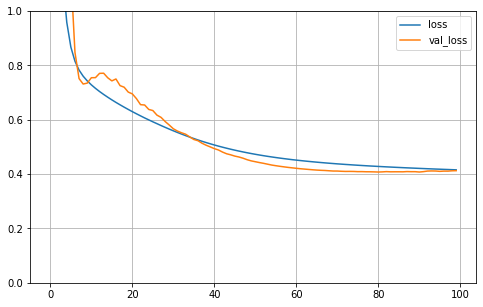

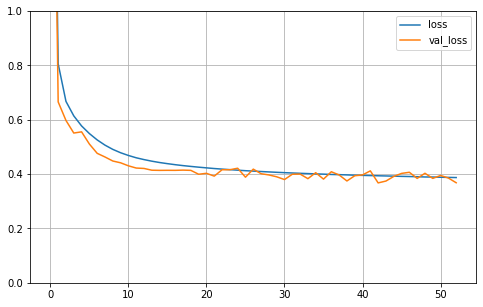

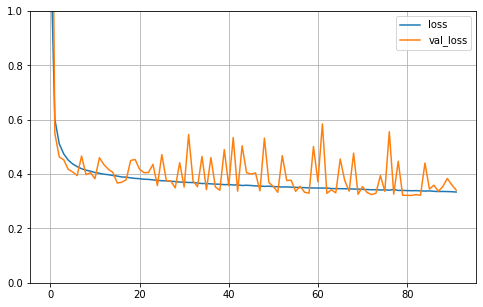

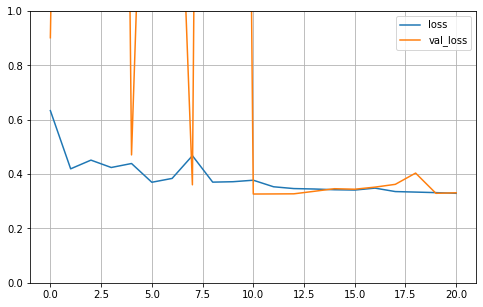

In [52]:
for hist in histories:
    plot_ler_cur(hist)

### 6.2)
Let's look at a more sophisticated way to tune hyperparameters. Create a `build_model()` function that takes three arguments, `n_hidden`, `n_neurons`, `learning_rate`, and builds, compiles and returns a model with the given number of hidden layers, the given number of neurons and the given learning rate. It is good practice to give a reasonable default value to each argument.

In [58]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=1e-3):
    model = keras.models.Sequential()
    options = {"input_shape" :X_train.shape[1:]}
    for layer in range(n_hidden+1):
        model.add(keras.layers.Dense(30, activation="relu", **options))
        options = {}
    model.add(keras.layers.Dense(1, **options))
    
    optimizer = keras.optimizers.SGD(learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model

### 6.3)
Create a `keras.wrappers.scikit_learn.KerasRegressor` and pass the `build_model` function to the constructor. This gives you a Scikit-Learn compatible predictor. Try training it and using it to make predictions. Note that you can pass the `n_epochs`, `callbacks` and `validation_data` to the `fit()` method.

In [59]:
model = keras.wrappers.scikit_learn.KerasRegressor(build_model)

In [61]:
callbacks = [keras.callbacks.EarlyStopping(patience=10)]


model.fit(X_train_scaled, y_train,
          validation_data=(X_valid_scaled, y_valid), epochs=100,
          callbacks=callbacks)

Epoch 1/100
363/363 [==============================] - 1s 2ms/step - loss: 2.4240 - val_loss: 6.3881
Epoch 2/100
363/363 [==============================] - 1s 2ms/step - loss: 0.9305 - val_loss: 1.0314
Epoch 3/100
363/363 [==============================] - 1s 2ms/step - loss: 0.6900 - val_loss: 0.8678
Epoch 4/100
363/363 [==============================] - 1s 2ms/step - loss: 0.6249 - val_loss: 0.6467
Epoch 5/100
363/363 [==============================] - 1s 3ms/step - loss: 0.5829 - val_loss: 0.5533
Epoch 6/100
363/363 [==============================] - 1s 2ms/step - loss: 0.5485 - val_loss: 0.5277
Epoch 7/100
363/363 [==============================] - 1s 2ms/step - loss: 0.5211 - val_loss: 0.4778
Epoch 8/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4975 - val_loss: 0.4590
Epoch 9/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4784 - val_loss: 0.4515
Epoch 10/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4632 - val_lo

In [67]:
prediction = model.predict(scaled_X_test[:100])

In [70]:
prediction

array([2.2483413 , 0.5836303 , 2.6788058 , 1.4166212 , 2.866412  ,
       3.2884147 , 3.2746584 , 1.2658489 , 1.4302093 , 1.5968332 ,
       2.0059671 , 1.0877925 , 1.2083571 , 2.7008593 , 1.0016534 ,
       1.5562541 , 3.8626335 , 1.6141822 , 1.198808  , 2.6826499 ,
       0.39941612, 1.6766987 , 0.8193693 , 2.0988662 , 3.047243  ,
       1.2003591 , 1.0487474 , 2.3863368 , 4.324234  , 1.3891109 ,
       0.61623466, 0.9874406 , 3.1140633 , 0.9292357 , 3.1407099 ,
       1.4613875 , 0.9031389 , 2.8576791 , 2.562347  , 1.0081286 ,
       0.6334405 , 2.5683632 , 1.9670334 , 2.5663235 , 0.99531174,
       1.711163  , 2.9800906 , 2.406191  , 1.6026621 , 0.7512828 ,
       2.6683269 , 2.0419338 , 0.81148213, 2.4286542 , 2.5364587 ,
       1.8760929 , 2.2016969 , 2.8060489 , 2.4803488 , 1.7933815 ,
       1.6394012 , 2.4773576 , 1.349813  , 2.894296  , 1.2059801 ,
       2.327261  , 2.741957  , 0.6198533 , 3.0597363 , 0.73770285,
       1.078786  , 1.9305379 , 0.4642113 , 2.261901  , 2.70890

### 6.4)
Use a `sklearn.model_selection.RandomizedSearchCV` to search the hyperparameter space of your `KerasRegressor`.

**Tips**:
* create a `param_distribs` dictionary where each key is the name of a hyperparameter you want to fine-tune (e.g., `"n_hidden"`), and each value is the list of values you want to explore (e.g., `[0, 1, 2, 3]`), or a Scipy distribution from `scipy.stats`.
* You can use the reciprocal distribution for the learning rate (e.g, `reciprocal(3e-3, 3e-2)`).
* Create a `RandomizedSearchCV`, passing the `KerasRegressor` and the `param_distribs` to its constructor, as well as the number of iterations (`n_iter`), and the number of cross-validation folds (`cv`). If you are short on time, you can set `n_iter=10` and `cv=3`. You may also want to set `verbose=2`.
* Finally, call the `RandomizedSearchCV`'s `fit()` method on the training set. Once again you can pass it `n_epochs`, `validation_data` and `callbacks` if you want to.
* The best parameters found will be available in the `best_params_` attribute, the best score will be in `best_score_`, and the best model will be in `best_estimator_`.

In [73]:
model = keras.wrappers.scikit_learn.KerasRegressor(build_model)

In [74]:
from scipy.stats import reciprocal

param_distribs = {
    "n_hidden": [0, 1, 2, 3],
    "n_neurons": np.arange(1, 100).tolist(),
    "learning_rate": reciprocal(3e-4, 3e-2).rvs(1000).tolist(),
}

In [77]:
from sklearn.model_selection import RandomizedSearchCV

In [78]:
rscv = RandomizedSearchCV(model, param_distribs, n_iter=10,cv=3, verbose=2)

In [79]:
rscv.fit(X_train_scaled, y_train,
          validation_data=(X_valid_scaled, y_valid), epochs=100,
          callbacks=callbacks)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] n_neurons=16, n_hidden=3, learning_rate=0.0004382507481797342 ...
Epoch 1/100


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


242/242 [==============================] - 1s 4ms/step - loss: 3.2789 - val_loss: 5.2448
Epoch 2/100
242/242 [==============================] - 1s 3ms/step - loss: 1.5404 - val_loss: 4.0384
Epoch 3/100
242/242 [==============================] - 1s 3ms/step - loss: 1.1937 - val_loss: 1.7418
Epoch 4/100
242/242 [==============================] - 1s 3ms/step - loss: 1.0198 - val_loss: 1.1822
Epoch 5/100
242/242 [==============================] - 1s 3ms/step - loss: 0.9049 - val_loss: 1.0006
Epoch 6/100
242/242 [==============================] - 1s 3ms/step - loss: 0.8187 - val_loss: 0.8812
Epoch 7/100
242/242 [==============================] - 1s 3ms/step - loss: 0.7509 - val_loss: 0.7758
Epoch 8/100
242/242 [==============================] - 1s 3ms/step - loss: 0.6997 - val_loss: 0.7099
Epoch 9/100
242/242 [==============================] - 1s 3ms/step - loss: 0.6622 - val_loss: 0.6607
Epoch 10/100
242/242 [==============================] - 1s 3ms/step - loss: 0.6347 - val_loss: 0.6224
E

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min remaining:    0.0s


242/242 [==============================] - 1s 3ms/step - loss: 3.0215 - val_loss: 5.2532
Epoch 2/100
242/242 [==============================] - 1s 2ms/step - loss: 1.1860 - val_loss: 5.3778
Epoch 3/100
242/242 [==============================] - 1s 3ms/step - loss: 0.9261 - val_loss: 3.9670
Epoch 4/100
242/242 [==============================] - 1s 3ms/step - loss: 0.8250 - val_loss: 2.9994
Epoch 5/100
242/242 [==============================] - 1s 3ms/step - loss: 0.7693 - val_loss: 2.3175
Epoch 6/100
242/242 [==============================] - 1s 2ms/step - loss: 0.7329 - val_loss: 1.8195
Epoch 7/100
242/242 [==============================] - 1s 3ms/step - loss: 0.7051 - val_loss: 1.4408
Epoch 8/100
242/242 [==============================] - 1s 3ms/step - loss: 0.6821 - val_loss: 1.2118
Epoch 9/100
242/242 [==============================] - 1s 3ms/step - loss: 0.6618 - val_loss: 1.0534
Epoch 10/100
242/242 [==============================] - 1s 3ms/step - loss: 0.6433 - val_loss: 0.9474
E

242/242 [==============================] - 1s 3ms/step - loss: 0.3315 - val_loss: 0.3384
Epoch 16/100
242/242 [==============================] - 1s 2ms/step - loss: 0.3305 - val_loss: 0.3470
Epoch 17/100
242/242 [==============================] - 1s 3ms/step - loss: 0.3279 - val_loss: 0.3416
Epoch 18/100
242/242 [==============================] - 1s 2ms/step - loss: 0.3238 - val_loss: 0.3067
Epoch 19/100
242/242 [==============================] - 1s 2ms/step - loss: 0.3211 - val_loss: 0.3132
Epoch 20/100
242/242 [==============================] - 1s 2ms/step - loss: 0.3182 - val_loss: 0.3101
Epoch 21/100
242/242 [==============================] - 1s 2ms/step - loss: 0.3168 - val_loss: 0.3044
Epoch 22/100
242/242 [==============================] - 1s 2ms/step - loss: 0.3129 - val_loss: 0.3950
Epoch 23/100
242/242 [==============================] - 1s 2ms/step - loss: 0.3156 - val_loss: 0.3119
Epoch 24/100
242/242 [==============================] - 1s 3ms/step - loss: 0.3121 - val_loss: 

242/242 [==============================] - 1s 2ms/step - loss: 0.6519 - val_loss: 1.6710
Epoch 15/100
242/242 [==============================] - 1s 2ms/step - loss: 0.6337 - val_loss: 1.3143
Epoch 16/100
242/242 [==============================] - 1s 2ms/step - loss: 0.6172 - val_loss: 1.0218
Epoch 17/100
242/242 [==============================] - 0s 2ms/step - loss: 0.6010 - val_loss: 0.7890
Epoch 18/100
242/242 [==============================] - 1s 2ms/step - loss: 0.5857 - val_loss: 0.6213
Epoch 19/100
242/242 [==============================] - 0s 2ms/step - loss: 0.5717 - val_loss: 0.5583
Epoch 20/100
242/242 [==============================] - 1s 2ms/step - loss: 0.5578 - val_loss: 0.5295
Epoch 21/100
242/242 [==============================] - 1s 3ms/step - loss: 0.5450 - val_loss: 0.5259
Epoch 22/100
242/242 [==============================] - 1s 2ms/step - loss: 0.5330 - val_loss: 0.5376
Epoch 23/100
242/242 [==============================] - 1s 3ms/step - loss: 0.5213 - val_loss: 

242/242 [==============================] - 1s 3ms/step - loss: 0.5370 - val_loss: 0.5176
Epoch 40/100
242/242 [==============================] - 1s 2ms/step - loss: 0.5322 - val_loss: 0.5152
Epoch 41/100
242/242 [==============================] - 1s 2ms/step - loss: 0.5277 - val_loss: 0.5102
Epoch 42/100
242/242 [==============================] - 1s 3ms/step - loss: 0.5233 - val_loss: 0.5067
Epoch 43/100
242/242 [==============================] - 0s 2ms/step - loss: 0.5190 - val_loss: 0.5036
Epoch 44/100
242/242 [==============================] - 0s 2ms/step - loss: 0.5149 - val_loss: 0.4975
Epoch 45/100
242/242 [==============================] - 0s 2ms/step - loss: 0.5109 - val_loss: 0.4914
Epoch 46/100
242/242 [==============================] - 0s 2ms/step - loss: 0.5071 - val_loss: 0.4878
Epoch 47/100
242/242 [==============================] - 0s 2ms/step - loss: 0.5034 - val_loss: 0.4843
Epoch 48/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4998 - val_loss: 

242/242 [==============================] - 0s 2ms/step - loss: 0.4518 - val_loss: 0.4249
Epoch 61/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4503 - val_loss: 0.4240
Epoch 62/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4489 - val_loss: 0.4229
Epoch 63/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4475 - val_loss: 0.4219
Epoch 64/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4462 - val_loss: 0.4211
Epoch 65/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4449 - val_loss: 0.4216
Epoch 66/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4437 - val_loss: 0.4191
Epoch 67/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4425 - val_loss: 0.4182
Epoch 68/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4414 - val_loss: 0.4179
Epoch 69/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4404 - val_loss: 

242/242 [==============================] - 0s 2ms/step - loss: 0.3654 - val_loss: 0.3660
Epoch 70/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3648 - val_loss: 0.3664
Epoch 71/100
242/242 [==============================] - 1s 2ms/step - loss: 0.3644 - val_loss: 0.3717
Epoch 72/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3635 - val_loss: 0.3761
Epoch 73/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3634 - val_loss: 0.3765
Epoch 74/100
242/242 [==============================] - 1s 3ms/step - loss: 0.3627 - val_loss: 0.3687
Epoch 75/100
121/121 [==============================] - 0s 1ms/step - loss: 0.3623
[CV]  n_neurons=35, n_hidden=1, learning_rate=0.000864303996142863, total=  43.0s
[CV] n_neurons=69, n_hidden=2, learning_rate=0.00038428418016145534 ..
Epoch 1/100
242/242 [==============================] - 1s 3ms/step - loss: 3.2981 - val_loss: 18.3282
Epoch 2/100
242/242 [==============================] - 0s 2ms/s

242/242 [==============================] - 1s 2ms/step - loss: 0.4122 - val_loss: 0.4322
Epoch 43/100
242/242 [==============================] - 1s 2ms/step - loss: 0.4108 - val_loss: 0.4446
Epoch 44/100
242/242 [==============================] - 1s 2ms/step - loss: 0.4095 - val_loss: 0.4391
Epoch 45/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4081 - val_loss: 0.4354
Epoch 46/100
242/242 [==============================] - 1s 2ms/step - loss: 0.4068 - val_loss: 0.4362
Epoch 47/100
242/242 [==============================] - 1s 2ms/step - loss: 0.4054 - val_loss: 0.4273
Epoch 48/100
242/242 [==============================] - 1s 2ms/step - loss: 0.4044 - val_loss: 0.4382
Epoch 49/100
242/242 [==============================] - 1s 2ms/step - loss: 0.4033 - val_loss: 0.4359
Epoch 50/100
242/242 [==============================] - 1s 2ms/step - loss: 0.4021 - val_loss: 0.4247
Epoch 51/100
242/242 [==============================] - 1s 2ms/step - loss: 0.4011 - val_loss: 

242/242 [==============================] - 1s 2ms/step - loss: 0.9010 - val_loss: 0.7459
Epoch 3/100
242/242 [==============================] - 0s 2ms/step - loss: 0.7009 - val_loss: 0.6534
Epoch 4/100
242/242 [==============================] - 1s 2ms/step - loss: 0.6472 - val_loss: 0.6252
Epoch 5/100
242/242 [==============================] - 1s 4ms/step - loss: 0.6163 - val_loss: 0.6013
Epoch 6/100
242/242 [==============================] - 1s 2ms/step - loss: 0.5913 - val_loss: 0.5786
Epoch 7/100
242/242 [==============================] - 1s 2ms/step - loss: 0.5695 - val_loss: 0.5560
Epoch 8/100
242/242 [==============================] - 1s 2ms/step - loss: 0.5502 - val_loss: 0.5332
Epoch 9/100
242/242 [==============================] - 1s 2ms/step - loss: 0.5331 - val_loss: 0.5143
Epoch 10/100
242/242 [==============================] - 1s 2ms/step - loss: 0.5183 - val_loss: 0.4963
Epoch 11/100
242/242 [==============================] - 1s 2ms/step - loss: 0.5048 - val_loss: 0.4815


242/242 [==============================] - 0s 2ms/step - loss: 0.2788 - val_loss: 0.2908
Epoch 61/100
242/242 [==============================] - 0s 2ms/step - loss: 0.2778 - val_loss: 0.2840
Epoch 62/100
242/242 [==============================] - 0s 2ms/step - loss: 0.2772 - val_loss: 0.2769
Epoch 63/100
242/242 [==============================] - 1s 3ms/step - loss: 0.2761 - val_loss: 0.2853
Epoch 64/100
242/242 [==============================] - 1s 3ms/step - loss: 0.2752 - val_loss: 0.2986
Epoch 65/100
242/242 [==============================] - 1s 3ms/step - loss: 0.2745 - val_loss: 0.3221
Epoch 66/100
242/242 [==============================] - 1s 3ms/step - loss: 0.2754 - val_loss: 0.2915
Epoch 67/100
242/242 [==============================] - 0s 2ms/step - loss: 0.2742 - val_loss: 0.2767
Epoch 68/100
242/242 [==============================] - 0s 2ms/step - loss: 0.2724 - val_loss: 0.3043
Epoch 69/100
242/242 [==============================] - 0s 2ms/step - loss: 0.2717 - val_loss: 

242/242 [==============================] - 0s 2ms/step - loss: 0.7608 - val_loss: 0.8367
Epoch 5/100
242/242 [==============================] - 0s 2ms/step - loss: 0.6893 - val_loss: 0.6698
Epoch 6/100
242/242 [==============================] - 0s 2ms/step - loss: 0.6428 - val_loss: 0.6055
Epoch 7/100
242/242 [==============================] - 0s 2ms/step - loss: 0.6088 - val_loss: 0.5649
Epoch 8/100
242/242 [==============================] - 1s 3ms/step - loss: 0.5825 - val_loss: 0.5376
Epoch 9/100
242/242 [==============================] - 1s 2ms/step - loss: 0.5602 - val_loss: 0.5186
Epoch 10/100
242/242 [==============================] - 1s 3ms/step - loss: 0.5410 - val_loss: 0.5026
Epoch 11/100
242/242 [==============================] - 1s 2ms/step - loss: 0.5245 - val_loss: 0.4864
Epoch 12/100
242/242 [==============================] - 0s 2ms/step - loss: 0.5094 - val_loss: 0.4738
Epoch 13/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4958 - val_loss: 0.462

Epoch 1/100
242/242 [==============================] - 1s 3ms/step - loss: 2.9854 - val_loss: 6.4832
Epoch 2/100
242/242 [==============================] - 0s 2ms/step - loss: 1.2542 - val_loss: 2.7952
Epoch 3/100
242/242 [==============================] - 0s 2ms/step - loss: 0.9493 - val_loss: 1.6925
Epoch 4/100
242/242 [==============================] - 0s 2ms/step - loss: 0.8502 - val_loss: 1.2252
Epoch 5/100
242/242 [==============================] - 0s 2ms/step - loss: 0.7962 - val_loss: 0.9485
Epoch 6/100
242/242 [==============================] - 0s 2ms/step - loss: 0.7570 - val_loss: 0.8289
Epoch 7/100
242/242 [==============================] - 1s 3ms/step - loss: 0.7252 - val_loss: 0.7549
Epoch 8/100
242/242 [==============================] - 1s 4ms/step - loss: 0.6986 - val_loss: 0.7057
Epoch 9/100
242/242 [==============================] - 1s 3ms/step - loss: 0.6751 - val_loss: 0.6616
Epoch 10/100
242/242 [==============================] - 0s 2ms/step - loss: 0.6538 - val_lo

242/242 [==============================] - 1s 3ms/step - loss: 0.2837 - val_loss: 0.4142
Epoch 31/100
242/242 [==============================] - 1s 3ms/step - loss: 0.2847 - val_loss: 0.3210
Epoch 32/100
242/242 [==============================] - 1s 3ms/step - loss: 0.2813 - val_loss: 0.3046
Epoch 33/100
242/242 [==============================] - 1s 3ms/step - loss: 0.2811 - val_loss: 0.3196
Epoch 34/100
242/242 [==============================] - 1s 3ms/step - loss: 0.2778 - val_loss: 0.3205
Epoch 35/100
242/242 [==============================] - 1s 3ms/step - loss: 0.2807 - val_loss: 0.5046
Epoch 36/100
121/121 [==============================] - 0s 2ms/step - loss: 0.3023
[CV]  n_neurons=81, n_hidden=3, learning_rate=0.022282585056494286, total=  24.2s
Epoch 1/100


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 16.8min finished


363/363 [==============================] - 1s 3ms/step - loss: 0.5758 - val_loss: 1.2656
Epoch 2/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3957 - val_loss: 0.6284
Epoch 3/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3705 - val_loss: 1.9139
Epoch 4/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3582 - val_loss: 0.6822
Epoch 5/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3590 - val_loss: 4.4998
Epoch 6/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3902 - val_loss: 0.4070
Epoch 7/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3921 - val_loss: 0.7544
Epoch 8/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3540 - val_loss: 0.3736
Epoch 9/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3376 - val_loss: 0.3436
Epoch 10/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3287 - val_loss: 0.3323
E

RandomizedSearchCV(cv=3,
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7f5b50faac18>,
                   param_distributions={'learning_rate': [0.0010525492762163775,
                                                          0.0024766493817585332,
                                                          0.0005716460266045342,
                                                          0.0034847274746607026,
                                                          0.002075575869914911,
                                                          0.0033952273022654,
                                                          0.0012490011810243442,
                                                          0.0012874883308774225,
                                                          0.00889764202932732,
                                                          0...
                                                          0.01030247852

In [80]:
rscv.best_params_

{'n_neurons': 81, 'n_hidden': 3, 'learning_rate': 0.022282585056494286}

{'n_neurons': 96, 'n_hidden': 2, 'learning_rate': 0.028200713021500724}

In [81]:
rscv.best_score_

-0.31285010774930316

In [82]:
rscv.best_estimator_

### 6.5)
Evaluate the best model found on the test set. You can either use the best estimator's `score()` method, or get its underlying Keras model *via* its `model` attribute, and call this model's `evaluate()` method. Note that the estimator returns the negative mean square error (it's a score, not a loss, so higher is better).

In [86]:
rscv.score(scaled_X_test[:4128],y_test[:4128])

129/129 [==============================] - 0s 2ms/step - loss: 2.2377


-2.2377443313598633

In [88]:
model = rscv.best_estimator_.model

In [90]:
model.evaluate(X_test_scaled, y_test)

162/162 [==============================] - 0s 2ms/step - loss: 0.2779


0.27791228890419006

### 6.6)
Finally, save the best Keras model found. **Tip**: it is available via the best estimator's `model` attribute, and just need to call its `save()` method.

**Tip**: while a randomized search is nice and simple, there are more powerful (but complex) options available out there for hyperparameter search, for example:
* [Hyperopt](https://github.com/hyperopt/hyperopt)
* [Hyperas](https://github.com/maxpumperla/hyperas)
* [Sklearn-Deap](https://github.com/rsteca/sklearn-deap)
* [Scikit-Optimize](https://scikit-optimize.github.io/)
* [Spearmint](https://github.com/JasperSnoek/spearmint)
* [PyMC3](https://docs.pymc.io/)
* [GPFlow](https://gpflow.readthedocs.io/)
* [Yelp/MOE](https://github.com/Yelp/MOE)
* Commercial services such as: [Google Cloud ML Engine](https://cloud.google.com/ml-engine/docs/tensorflow/using-hyperparameter-tuning), [Arimo](https://arimo.com/) or [Oscar](http://oscar.calldesk.ai/)

![Exercise solution](https://camo.githubusercontent.com/250388fde3fac9135ead9471733ee28e049f7a37/68747470733a2f2f75706c6f61642e77696b696d656469612e6f72672f77696b6970656469612f636f6d6d6f6e732f302f30362f46696c6f735f736567756e646f5f6c6f676f5f253238666c69707065642532392e6a7067)

## Exercise 6 – Solution

### 6.1)
Try training your model multiple times, with different a learning rate each time (e.g., 1e-4, 3e-4, 1e-3, 3e-3, 3e-2), and compare the learning curves. For this, you need to create a `keras.optimizers.SGD` optimizer and specify the `learning_rate` in its constructor, then pass this `SGD` instance to the `compile()` method using the `optimizer` argument.

In [91]:
learning_rates = [1e-4, 3e-4, 1e-3, 3e-3, 1e-2, 3e-2]
histories = []
for learning_rate in learning_rates:
    model = keras.models.Sequential([
        keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
        keras.layers.Dense(1)
    ])
    optimizer = keras.optimizers.SGD(learning_rate)
    model.compile(loss="mean_squared_error", optimizer=optimizer)
    callbacks = [keras.callbacks.EarlyStopping(patience=10)]
    history = model.fit(X_train_scaled, y_train,
                        validation_data=(X_valid_scaled, y_valid), epochs=100,
                        callbacks=callbacks)
    histories.append(history)

Epoch 1/100
363/363 [==============================] - 1s 2ms/step - loss: 5.7149 - val_loss: 5.2409
Epoch 2/100
363/363 [==============================] - 1s 2ms/step - loss: 3.9252 - val_loss: 3.1765
Epoch 3/100
363/363 [==============================] - 1s 2ms/step - loss: 2.8695 - val_loss: 2.4563
Epoch 4/100
363/363 [==============================] - 1s 2ms/step - loss: 2.2127 - val_loss: 2.1912
Epoch 5/100
363/363 [==============================] - 1s 2ms/step - loss: 1.7863 - val_loss: 2.0624
Epoch 6/100
363/363 [==============================] - 1s 2ms/step - loss: 1.5000 - val_loss: 1.9320
Epoch 7/100
363/363 [==============================] - 1s 2ms/step - loss: 1.3018 - val_loss: 1.7768
Epoch 8/100
363/363 [==============================] - 1s 2ms/step - loss: 1.1601 - val_loss: 1.6126
Epoch 9/100
363/363 [==============================] - 1s 2ms/step - loss: 1.0560 - val_loss: 1.4444
Epoch 10/100
363/363 [==============================] - 1s 2ms/step - loss: 0.9781 - val_lo

363/363 [==============================] - 1s 2ms/step - loss: 0.3976 - val_loss: 0.4020
Epoch 31/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3960 - val_loss: 0.4056
Epoch 32/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3946 - val_loss: 0.3942
Epoch 33/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3933 - val_loss: 0.3918
Epoch 34/100
363/363 [==============================] - 1s 3ms/step - loss: 0.3921 - val_loss: 0.3809
Epoch 35/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3909 - val_loss: 0.3800
Epoch 36/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3897 - val_loss: 0.3786
Epoch 37/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3887 - val_loss: 0.3761
Epoch 38/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3876 - val_loss: 0.3788
Epoch 39/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3865 - val_loss: 

Learning rate: 0.0001


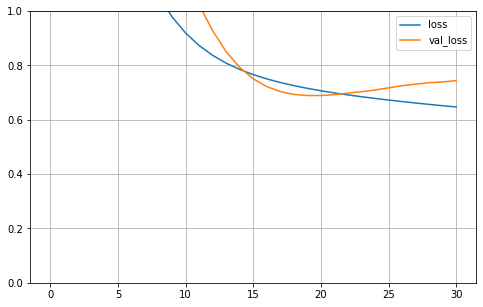

Learning rate: 0.0003


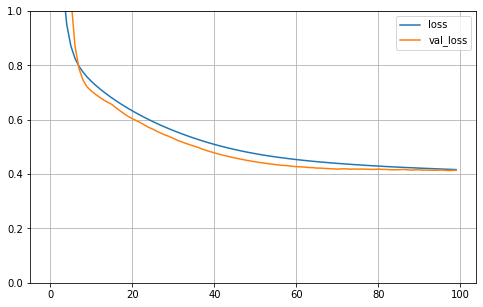

Learning rate: 0.001


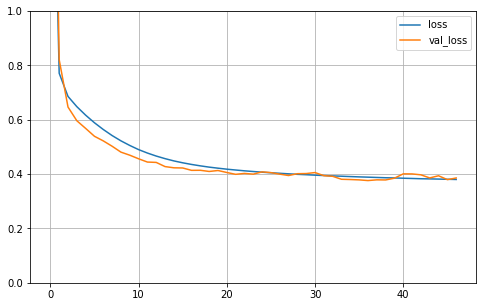

Learning rate: 0.003


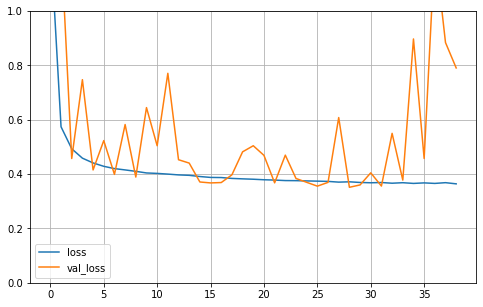

Learning rate: 0.01


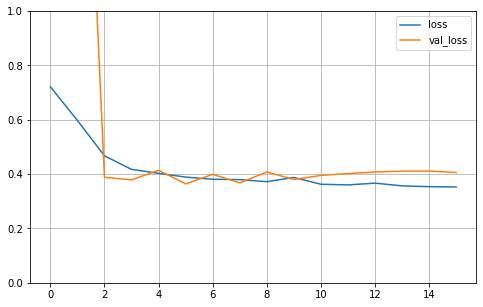

Learning rate: 0.03


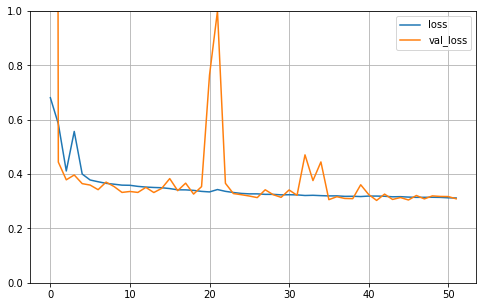

In [93]:
for learning_rate, history in zip(learning_rates, histories):
    print("Learning rate:", learning_rate)
    plot_ler_cur(history)

### 6.2)
Let's look at a more sophisticated way to tune hyperparameters. Create a `build_model()` function that takes three arguments, `n_hidden`, `n_neurons`, `learning_rate`, and builds, compiles and returns a model with the given number of hidden layers, the given number of neurons and the given learning rate. It is good practice to give a reasonable default value to each argument.

In [94]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3):
    model = keras.models.Sequential()
    options = {"input_shape": X_train.shape[1:]}
    for layer in range(n_hidden + 1):
        model.add(keras.layers.Dense(n_neurons, activation="relu", **options))
        options = {}
    model.add(keras.layers.Dense(1, **options))
    optimizer = keras.optimizers.SGD(learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model

### 6.3)
Create a `keras.wrappers.scikit_learn.KerasRegressor` and pass the `build_model` function to the constructor. This gives you a Scikit-Learn compatible predictor. Try training it and using it to make predictions. Note that you can pass the `n_epochs`, `callbacks` and `validation_data` to the `fit()` method.

In [95]:
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

In [96]:
keras_reg.fit(X_train_scaled, y_train, epochs=100,
              validation_data=(X_valid_scaled, y_valid),
              callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/100
363/363 [==============================] - 1s 2ms/step - loss: 1.2090 - val_loss: 1.0070
Epoch 2/100
363/363 [==============================] - 1s 2ms/step - loss: 0.5666 - val_loss: 0.6496
Epoch 3/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4815 - val_loss: 0.5240
Epoch 4/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4435 - val_loss: 0.4743
Epoch 5/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4227 - val_loss: 0.4503
Epoch 6/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4106 - val_loss: 0.4487
Epoch 7/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4005 - val_loss: 0.4403
Epoch 8/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3932 - val_loss: 0.4528
Epoch 9/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3865 - val_loss: 0.4653
Epoch 10/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3811 - val_lo

In [97]:
keras_reg.predict(X_test_scaled)

array([0.7045049, 1.6695809, 4.446439 , ..., 1.4601827, 2.5656137,
       4.1751614], dtype=float32)

### 6.4)
Use a `sklearn.model_selection.RandomizedSearchCV` to search the hyperparameter space of your `KerasRegressor`.

**Warning**: due to a change in Scikit-Learn, the following code breaks if we don't use `.tolist()` and `.rvs(1000).tolist()`. See [Keras issue #13586](https://github.com/keras-team/keras/issues/13586) for more details.

In [98]:
from scipy.stats import reciprocal

param_distribs = {
    "n_hidden": [0, 1, 2, 3],
    "n_neurons": np.arange(1, 100).tolist(),
    "learning_rate": reciprocal(3e-4, 3e-2).rvs(1000).tolist(),
}

In [99]:
from sklearn.model_selection import RandomizedSearchCV

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=3, verbose=2)

In [100]:
rnd_search_cv.fit(X_train_scaled, y_train, epochs=100,
                  validation_data=(X_valid_scaled, y_valid),
                  callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] n_neurons=3, n_hidden=2, learning_rate=0.00038170880536021984 ...
Epoch 1/100


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


242/242 [==============================] - 1s 3ms/step - loss: 4.4571 - val_loss: 3.3776
Epoch 2/100
242/242 [==============================] - 1s 3ms/step - loss: 2.8594 - val_loss: 2.1486
Epoch 3/100
242/242 [==============================] - 1s 2ms/step - loss: 1.9082 - val_loss: 1.5809
Epoch 4/100
242/242 [==============================] - 1s 2ms/step - loss: 1.5158 - val_loss: 1.3722
Epoch 5/100
242/242 [==============================] - 1s 2ms/step - loss: 1.3569 - val_loss: 1.2728
Epoch 6/100
242/242 [==============================] - 1s 3ms/step - loss: 1.2707 - val_loss: 1.2065
Epoch 7/100
242/242 [==============================] - 1s 3ms/step - loss: 1.2086 - val_loss: 1.1511
Epoch 8/100
242/242 [==============================] - 1s 3ms/step - loss: 1.1529 - val_loss: 1.0987
Epoch 9/100
242/242 [==============================] - 1s 3ms/step - loss: 1.1012 - val_loss: 1.0504
Epoch 10/100
242/242 [==============================] - 1s 3ms/step - loss: 1.0536 - val_loss: 1.0028
E

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min remaining:    0.0s


242/242 [==============================] - 1s 3ms/step - loss: 4.5059 - val_loss: 5.7708
Epoch 2/100
242/242 [==============================] - 1s 3ms/step - loss: 3.2299 - val_loss: 5.8657
Epoch 3/100
242/242 [==============================] - 1s 2ms/step - loss: 2.3785 - val_loss: 6.5268
Epoch 4/100
242/242 [==============================] - 1s 3ms/step - loss: 1.8668 - val_loss: 7.1897
Epoch 5/100
242/242 [==============================] - 1s 3ms/step - loss: 1.5823 - val_loss: 7.5208
Epoch 6/100
242/242 [==============================] - 1s 3ms/step - loss: 1.4204 - val_loss: 7.5306
Epoch 7/100
242/242 [==============================] - 1s 2ms/step - loss: 1.3202 - val_loss: 7.3615
Epoch 8/100
242/242 [==============================] - 1s 3ms/step - loss: 1.2451 - val_loss: 7.1711
Epoch 9/100
242/242 [==============================] - 1s 3ms/step - loss: 1.1760 - val_loss: 7.0044
Epoch 10/100
242/242 [==============================] - 1s 2ms/step - loss: 1.1133 - val_loss: 6.9301
E

242/242 [==============================] - 1s 2ms/step - loss: 0.2807 - val_loss: 0.4149
Epoch 62/100
242/242 [==============================] - 1s 3ms/step - loss: 0.2805 - val_loss: 0.3504
Epoch 63/100
242/242 [==============================] - 1s 2ms/step - loss: 0.2797 - val_loss: 0.3876
Epoch 64/100
242/242 [==============================] - 1s 2ms/step - loss: 0.2806 - val_loss: 0.2864
Epoch 65/100
121/121 [==============================] - 0s 1ms/step - loss: 0.2946
[CV]  n_neurons=49, n_hidden=2, learning_rate=0.0050308646674258, total=  37.2s
[CV] n_neurons=68, n_hidden=3, learning_rate=0.001150485088877283 ....
Epoch 1/100
242/242 [==============================] - 1s 3ms/step - loss: 1.8588 - val_loss: 1.2277
Epoch 2/100
242/242 [==============================] - 1s 2ms/step - loss: 0.7931 - val_loss: 0.7373
Epoch 3/100
242/242 [==============================] - 1s 2ms/step - loss: 0.6570 - val_loss: 0.6172
Epoch 4/100
242/242 [==============================] - 1s 2ms/step -

242/242 [==============================] - 1s 2ms/step - loss: 0.3248 - val_loss: 0.3278
Epoch 70/100
242/242 [==============================] - 1s 3ms/step - loss: 0.3238 - val_loss: 0.3375
Epoch 71/100
242/242 [==============================] - 1s 2ms/step - loss: 0.3228 - val_loss: 0.3605
Epoch 72/100
242/242 [==============================] - 1s 2ms/step - loss: 0.3229 - val_loss: 0.3222
Epoch 73/100
242/242 [==============================] - 1s 2ms/step - loss: 0.3221 - val_loss: 0.3580
Epoch 74/100
242/242 [==============================] - 1s 2ms/step - loss: 0.3219 - val_loss: 0.3393
Epoch 75/100
242/242 [==============================] - 1s 2ms/step - loss: 0.3211 - val_loss: 0.3331
Epoch 76/100
242/242 [==============================] - 1s 2ms/step - loss: 0.3209 - val_loss: 0.3357
Epoch 77/100
242/242 [==============================] - 1s 2ms/step - loss: 0.3197 - val_loss: 0.3644
Epoch 78/100
242/242 [==============================] - 1s 2ms/step - loss: 0.3192 - val_loss: 

242/242 [==============================] - 1s 2ms/step - loss: 0.4298 - val_loss: 0.8058
Epoch 4/100
242/242 [==============================] - 1s 2ms/step - loss: 0.4011 - val_loss: 0.3916
Epoch 5/100
242/242 [==============================] - 1s 2ms/step - loss: 0.3829 - val_loss: 0.5697
Epoch 6/100
242/242 [==============================] - 1s 2ms/step - loss: 0.3740 - val_loss: 0.4417
Epoch 7/100
242/242 [==============================] - 1s 2ms/step - loss: 0.3621 - val_loss: 0.6220
Epoch 8/100
242/242 [==============================] - 1s 2ms/step - loss: 0.3550 - val_loss: 0.3747
Epoch 9/100
242/242 [==============================] - 1s 2ms/step - loss: 0.3484 - val_loss: 0.3371
Epoch 10/100
242/242 [==============================] - 1s 3ms/step - loss: 0.3422 - val_loss: 0.3947
Epoch 11/100
242/242 [==============================] - 1s 2ms/step - loss: 0.3399 - val_loss: 0.3722
Epoch 12/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3364 - val_loss: 0.3970

242/242 [==============================] - 1s 2ms/step - loss: 0.3578 - val_loss: 0.5699
Epoch 25/100
242/242 [==============================] - 1s 2ms/step - loss: 0.3551 - val_loss: 0.5754
Epoch 26/100
242/242 [==============================] - 1s 2ms/step - loss: 0.3531 - val_loss: 0.5993
Epoch 27/100
242/242 [==============================] - 1s 2ms/step - loss: 0.3514 - val_loss: 0.6095
Epoch 28/100
121/121 [==============================] - 0s 1ms/step - loss: 0.3614
[CV]  n_neurons=65, n_hidden=3, learning_rate=0.001280284409107457, total=  15.9s
[CV] n_neurons=65, n_hidden=3, learning_rate=0.001280284409107457 ....
Epoch 1/100
242/242 [==============================] - 1s 3ms/step - loss: 1.9320 - val_loss: 3.1046
Epoch 2/100
242/242 [==============================] - 1s 2ms/step - loss: 0.7380 - val_loss: 0.6438
Epoch 3/100
242/242 [==============================] - 1s 2ms/step - loss: 0.6048 - val_loss: 0.5434
Epoch 4/100
242/242 [==============================] - 1s 2ms/step

Epoch 1/100
242/242 [==============================] - 1s 2ms/step - loss: 0.6135 - val_loss: 5.6207
Epoch 2/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4242 - val_loss: 3.0497
Epoch 3/100
242/242 [==============================] - 0s 2ms/step - loss: 0.5062 - val_loss: 8.1546
Epoch 4/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4285 - val_loss: 4.5508
Epoch 5/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4651 - val_loss: 11.3945
Epoch 6/100
242/242 [==============================] - 0s 2ms/step - loss: 0.9353 - val_loss: 9.5249
Epoch 7/100
242/242 [==============================] - 1s 2ms/step - loss: 0.3708 - val_loss: 2.1363
Epoch 8/100
242/242 [==============================] - 1s 3ms/step - loss: 0.3663 - val_loss: 0.3246
Epoch 9/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3375 - val_loss: 0.3123
Epoch 10/100
242/242 [==============================] - 1s 5ms/step - loss: 0.3305 - val_l

242/242 [==============================] - 1s 2ms/step - loss: 0.4427 - val_loss: 0.4486
Epoch 39/100
242/242 [==============================] - 1s 2ms/step - loss: 0.4384 - val_loss: 0.4441
Epoch 40/100
242/242 [==============================] - 1s 3ms/step - loss: 0.4343 - val_loss: 0.4449
Epoch 41/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4301 - val_loss: 0.4380
Epoch 42/100
242/242 [==============================] - 1s 3ms/step - loss: 0.4267 - val_loss: 0.4384
Epoch 43/100
242/242 [==============================] - 1s 3ms/step - loss: 0.4231 - val_loss: 0.4365
Epoch 44/100
242/242 [==============================] - 1s 6ms/step - loss: 0.4199 - val_loss: 0.4372
Epoch 45/100
242/242 [==============================] - 1s 5ms/step - loss: 0.4167 - val_loss: 0.4361
Epoch 46/100
242/242 [==============================] - 1s 5ms/step - loss: 0.4138 - val_loss: 0.4408
Epoch 47/100
242/242 [==============================] - 1s 4ms/step - loss: 0.4112 - val_loss: 

242/242 [==============================] - 1s 3ms/step - loss: 0.3680 - val_loss: 0.3690
Epoch 40/100
242/242 [==============================] - 1s 2ms/step - loss: 0.3666 - val_loss: 0.3948
Epoch 41/100
242/242 [==============================] - 1s 3ms/step - loss: 0.3655 - val_loss: 0.3545
Epoch 42/100
242/242 [==============================] - 1s 3ms/step - loss: 0.3642 - val_loss: 0.3696
Epoch 43/100
242/242 [==============================] - 1s 3ms/step - loss: 0.3632 - val_loss: 0.3768
Epoch 44/100
242/242 [==============================] - 1s 3ms/step - loss: 0.3621 - val_loss: 0.3933
Epoch 45/100
242/242 [==============================] - 1s 3ms/step - loss: 0.3611 - val_loss: 0.3962
Epoch 46/100
242/242 [==============================] - 1s 3ms/step - loss: 0.3600 - val_loss: 0.3618
Epoch 47/100
242/242 [==============================] - 1s 3ms/step - loss: 0.3590 - val_loss: 0.3998
Epoch 48/100
242/242 [==============================] - 1s 3ms/step - loss: 0.3581 - val_loss: 

242/242 [==============================] - 1s 2ms/step - loss: 0.4533 - val_loss: 0.4289
Epoch 24/100
242/242 [==============================] - 1s 2ms/step - loss: 0.4492 - val_loss: 0.4282
Epoch 25/100
242/242 [==============================] - 1s 2ms/step - loss: 0.4453 - val_loss: 0.4253
Epoch 26/100
242/242 [==============================] - 1s 2ms/step - loss: 0.4416 - val_loss: 0.4187
Epoch 27/100
242/242 [==============================] - 1s 2ms/step - loss: 0.4384 - val_loss: 0.4169
Epoch 28/100
242/242 [==============================] - 1s 2ms/step - loss: 0.4353 - val_loss: 0.4180
Epoch 29/100
242/242 [==============================] - 1s 2ms/step - loss: 0.4325 - val_loss: 0.4161
Epoch 30/100
242/242 [==============================] - 1s 3ms/step - loss: 0.4299 - val_loss: 0.4106
Epoch 31/100
242/242 [==============================] - 1s 3ms/step - loss: 0.4276 - val_loss: 0.4111
Epoch 32/100
242/242 [==============================] - 1s 3ms/step - loss: 0.4253 - val_loss: 

242/242 [==============================] - 1s 4ms/step - loss: 0.4113 - val_loss: 0.4268
Epoch 31/100
242/242 [==============================] - 1s 3ms/step - loss: 0.4083 - val_loss: 0.4266
Epoch 32/100
242/242 [==============================] - 1s 2ms/step - loss: 0.4055 - val_loss: 0.4260
Epoch 33/100
242/242 [==============================] - 1s 3ms/step - loss: 0.4029 - val_loss: 0.4257
Epoch 34/100
242/242 [==============================] - 1s 2ms/step - loss: 0.4006 - val_loss: 0.4252
Epoch 35/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3981 - val_loss: 0.4248
Epoch 36/100
242/242 [==============================] - 1s 3ms/step - loss: 0.3960 - val_loss: 0.4234
Epoch 37/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3942 - val_loss: 0.4252
Epoch 38/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3923 - val_loss: 0.4241
Epoch 39/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3908 - val_loss: 

242/242 [==============================] - 1s 6ms/step - loss: 0.4088 - val_loss: 0.4120
Epoch 40/100
242/242 [==============================] - 1s 6ms/step - loss: 0.4063 - val_loss: 0.4138
Epoch 41/100
242/242 [==============================] - 1s 6ms/step - loss: 0.4039 - val_loss: 0.4156
Epoch 42/100
121/121 [==============================] - 0s 4ms/step - loss: 0.4050
[CV]  n_neurons=41, n_hidden=3, learning_rate=0.00040640110428604847, total=  43.9s


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 16.7min finished


Epoch 1/100
363/363 [==============================] - 2s 6ms/step - loss: 0.5332 - val_loss: 3.2192
Epoch 2/100
363/363 [==============================] - 2s 5ms/step - loss: 0.3873 - val_loss: 0.3702
Epoch 3/100
363/363 [==============================] - 2s 5ms/step - loss: 0.3646 - val_loss: 1.1466
Epoch 4/100
363/363 [==============================] - 2s 5ms/step - loss: 0.3779 - val_loss: 0.4492
Epoch 5/100
363/363 [==============================] - 2s 5ms/step - loss: 0.3490 - val_loss: 0.3125
Epoch 6/100
363/363 [==============================] - 2s 5ms/step - loss: 0.3340 - val_loss: 0.8377
Epoch 7/100
363/363 [==============================] - 2s 6ms/step - loss: 0.3261 - val_loss: 1.3999
Epoch 8/100
363/363 [==============================] - 2s 5ms/step - loss: 0.3377 - val_loss: 0.6705
Epoch 9/100
363/363 [==============================] - 2s 6ms/step - loss: 0.3215 - val_loss: 1.7008
Epoch 10/100
363/363 [==============================] - 2s 5ms/step - loss: 0.3308 - val_lo

RandomizedSearchCV(cv=3,
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7f5b7250c550>,
                   param_distributions={'learning_rate': [0.0003998024183642037,
                                                          0.001412854731966523,
                                                          0.010344617698789737,
                                                          0.004632806084196083,
                                                          0.005063601539537794,
                                                          0.014253380459529825,
                                                          0.016207317649457292,
                                                          0.0013159743280880688,
                                                          0.002192385813623791,
                                                          0....
                                                          0.00033287925

In [101]:
rnd_search_cv.best_params_

{'n_neurons': 96, 'n_hidden': 2, 'learning_rate': 0.028200713021500724}

In [102]:
rnd_search_cv.best_score_

-0.28741881251335144

In [103]:
rnd_search_cv.best_estimator_

### 6.5)
Evaluate the best model found on the test set. You can either use the best estimator's `score()` method, or get its underlying Keras model *via* its `model` attribute, and call this model's `evaluate()` method. Note that the estimator returns the negative mean square error (it's a score, not a loss, so higher is better).

In [104]:
rnd_search_cv.score(X_test_scaled, y_test)

162/162 [==============================] - 0s 2ms/step - loss: 0.2962


-0.29620084166526794

In [105]:
model = rnd_search_cv.best_estimator_.model
model.evaluate(X_test_scaled, y_test)

162/162 [==============================] - 0s 2ms/step - loss: 0.2962


0.29620084166526794

### 6.6)
Finally, save the best Keras model found. **Tip**: it is available via the best estimator's `model` attribute, and just need to call its `save()` method.

In [ ]:
model.save("my_fine_tuned_housing_model.h5")

![Exercise](https://c1.staticflickr.com/9/8101/8553474140_c50cf08708_b.jpg)

## Exercise 7 – The functional API

Not all neural network models are simply sequential. Some may have complex topologies. Some may have multiple inputs and/or multiple outputs. For example, a Wide & Deep neural network (see [paper](https://ai.google/research/pubs/pub45413)) connects all or part of the inputs directly to the output layer, as shown on the following diagram:

<img src="images/wide_and_deep_net.png" title="Wide and deep net" width=300 />

### 7.1)
Use Keras' functional API to implement a Wide & Deep network to tackle the California housing problem.

**Tips**:
* You need to create a `keras.layers.Input` layer to represent the inputs. Don't forget to specify the input `shape`.
* Create the `Dense` layers, and connect them by using them like functions. For example, `hidden1 = keras.layers.Dense(30, activation="relu")(input)` and `hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)`
* Use the `keras.layers.concatenate()` function to concatenate the input layer and the second hidden layer's output.
* Create a `keras.models.Model` and specify its `inputs` and `outputs` (e.g., `inputs=[input]`).
* Then use this model just like a `Sequential` model: you need to compile it, display its summary, train it, evaluate it and use it to make predictions.

In [17]:
input = keras.layers.Input(shape = X_train.shape[1:])
hidden1 = keras.layers.Dense(30,activation="relu")(input)
hidden2 = keras.layers.Dense(30,activation="relu")(hidden1)
concat = keras.layers.concatenate([input, hidden2])
output = keras.layers.Dense(1)(concat)

In [18]:
model = keras.models.Model(inputs=[input], outputs=[output])

In [20]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(1e-3))

In [21]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 30)           270         input_2[0][0]                    
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 30)           930         dense_3[0][0]                    
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 38)           0           input_2[0][0]                    
                                                                 dense_4[0][0]                

In [22]:
history = model.fit(X_train_scaled,y_train,
                   validation_data=(X_valid_scaled,y_valid), epochs=10)

Epoch 1/10
363/363 [==============================] - 1s 3ms/step - loss: 1.7526 - val_loss: 1.0065
Epoch 2/10
363/363 [==============================] - 1s 2ms/step - loss: 0.7155 - val_loss: 0.9034
Epoch 3/10
363/363 [==============================] - 1s 2ms/step - loss: 0.6449 - val_loss: 0.5871
Epoch 4/10
363/363 [==============================] - 1s 3ms/step - loss: 0.5954 - val_loss: 0.7766
Epoch 5/10
363/363 [==============================] - 1s 2ms/step - loss: 0.5566 - val_loss: 0.5592
Epoch 6/10
363/363 [==============================] - 1s 2ms/step - loss: 0.5281 - val_loss: 0.5226
Epoch 7/10
363/363 [==============================] - 1s 2ms/step - loss: 0.5032 - val_loss: 0.6076
Epoch 8/10
363/363 [==============================] - 1s 3ms/step - loss: 0.4850 - val_loss: 0.4539
Epoch 9/10
363/363 [==============================] - 1s 2ms/step - loss: 0.4709 - val_loss: 0.4439
Epoch 10/10
363/363 [==============================] - 1s 2ms/step - loss: 0.4586 - val_loss: 0.4295

<AxesSubplot:>

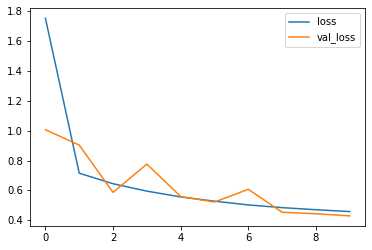

In [27]:
pd.DataFrame(history.history).plot()

In [24]:
model.evaluate(X_test_scaled, y_test)

162/162 [==============================] - 0s 1ms/step - loss: 0.4455


0.44552940130233765

In [25]:
model.predict(X_test_scaled)

array([[0.6324886],
       [1.5014019],
       [3.3095126],
       ...,
       [1.3502579],
       [2.7232337],
       [3.7615256]], dtype=float32)

### 7.2)
After the Sequential API and the Functional API, let's try the Subclassing API:
* Create a subclass of the `keras.models.Model` class.
* Create all the layers you need in the constructor (e.g., `self.hidden1 = keras.layers.Dense(...)`).
* Use the layers to process the `input` in the `call()` method, and return the output.
* Note that you do not need to create a `keras.layers.Input` in this case.
* Also note that `self.output` is used by Keras, so you should use another name for the output layer (e.g., `self.output_layer`).

**When should you use the Subclassing API?**
* Both the Sequential API and the Functional API are declarative: you first declare the list of layers you need and how they are connected, and only then can you feed your model with actual data. The models that these APIs build are just static graphs of layers. This has many advantages (easy inspection, debugging, saving, loading, sharing, etc.), and they cover the vast majority of use cases, but if you need to build a very dynamic model (e.g., with loops or conditional branching), or if you want to experiment with new ideas using an imperative programming style, then the Subclassing API is for you. You can pretty much do any computation you want in the `call()` method, possibly with loops and conditions, using Keras layers of even low-level TensorFlow operations.
* However, this extra flexibility comes at the cost of less transparency. Since the model is defined within the `call()` method, Keras cannot fully inspect it. All it sees is the list of model attributes (which include the layers you define in the constructor), so when you display the model summary you just see a list of unconnected layers. Consequently, you cannot save or load the model without writing extra code. So this API is best used only when you really need the extra flexibility.

In [ ]:
class MyModel(keras.models.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        # create layers here

    def call(self, input):
        # write any code here, using layers or even low-level TF code
        return output

model = MyModel()

### 7.3)
Now suppose you want to send only features 0 to 4 directly to the output, and only features 2 to 7 through the hidden layers, as shown on the following diagram. Use the functional API to build, train and evaluate this model.

**Tips**:
* You need to create two `keras.layers.Input` (`input_A` and `input_B`)
* Build the model using the functional API, as above, but when you build the `keras.models.Model`, remember to set `inputs=[input_A, input_B]`
* When calling `fit()`, `evaluate()` and  `predict()`, instead of passing `X_train_scaled`, pass `(X_train_scaled_A, X_train_scaled_B)` (two NumPy arrays containing only the appropriate features copied from `X_train_scaled`).

<img src="images/multiple_inputs.png" title="Multiple inputs" width=300 />

In [51]:
X_train_scaled_A = X_train_scaled[:,:5]
X_test_scaled_A = X_test_scaled[:,:5]
X_valid_scaled_A = X_valid_scaled[:,:5]

X_train_scaled_B = X_train_scaled[:,2:]
X_test_scaled_B = X_test_scaled[:,2:]
X_valid_scaled_B = X_valid_scaled[:,2:]

In [52]:
input_A = keras.layers.Input(shape=X_train_scaled_A.shape[1:])
input_B = keras.layers.Input(shape=X_train_scaled_B.shape[1:])

In [53]:
hidden1 = keras.layers.Dense(30,activation="relu")(input_B)
hidden2 = keras.layers.Dense(30,activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A,hidden2])
output = keras.layers.Dense(1)(concat)

In [54]:
model = keras.models.Model(inputs=[input_A,input_B], outputs=[output])

In [55]:
model.compile(loss="mse",optimizer=keras.optimizers.SGD(1e-3))

In [56]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 6)]          0                                            
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 30)           210         input_7[0][0]                    
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 5)]          0                                            
__________________________________________________________________________________________________
dense_10 (Dense)                (None, 30)           930         dense_9[0][0]                    
____________________________________________________________________________________________

In [57]:
history = model.fit([X_train_scaled_A, X_train_scaled_B],y_train,epochs=10,
                    validation_data=([X_valid_scaled_A,X_valid_scaled_B],y_valid))

Epoch 1/10
363/363 [==============================] - 1s 3ms/step - loss: 2.4055 - val_loss: 1.7207
Epoch 2/10
363/363 [==============================] - 1s 3ms/step - loss: 0.8709 - val_loss: 0.8864
Epoch 3/10
363/363 [==============================] - 1s 2ms/step - loss: 0.7247 - val_loss: 0.7174
Epoch 4/10
363/363 [==============================] - 1s 3ms/step - loss: 0.6591 - val_loss: 0.6648
Epoch 5/10
363/363 [==============================] - 1s 2ms/step - loss: 0.6070 - val_loss: 0.8085
Epoch 6/10
363/363 [==============================] - 1s 2ms/step - loss: 0.5695 - val_loss: 0.5210
Epoch 7/10
363/363 [==============================] - 1s 2ms/step - loss: 0.5417 - val_loss: 0.5144
Epoch 8/10
363/363 [==============================] - 1s 2ms/step - loss: 0.5185 - val_loss: 0.4828
Epoch 9/10
363/363 [==============================] - 1s 2ms/step - loss: 0.5008 - val_loss: 0.4653
Epoch 10/10
363/363 [==============================] - 1s 2ms/step - loss: 0.4881 - val_loss: 0.5727

<AxesSubplot:>

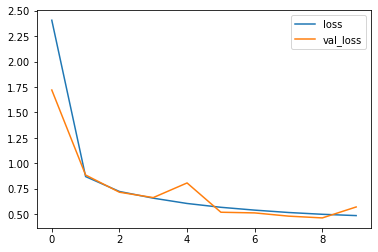

In [58]:
pd.DataFrame(history.history).plot()

In [59]:
model.evaluate([X_test_scaled_A, X_test_scaled_B], y_test)

162/162 [==============================] - 0s 2ms/step - loss: 0.4757


0.4756694436073303

In [60]:
model.predict([X_test_scaled_A, X_test_scaled_B])

array([[0.5770841],
       [1.5596001],
       [2.6687813],
       ...,
       [1.413094 ],
       [2.4271078],
       [3.5315673]], dtype=float32)

### 7.4)
Build the multi-input and multi-output neural net represented in the following diagram.

<img src="images/multiple_inputs_and_outputs.png" title="Multiple inputs and outputs" width=400 />

**Why?**

There are many use cases in which having multiple outputs can be useful:
* Your task may require multiple outputs, for example, you may want to locate and classify the main object in a picture. This is both a regression task (finding the coordinates of the object's center, as well as its width and height) and a classification task.
* Similarly, you may have multiple independent tasks to perform based on the same data. Sure, you could train one neural network per task, but in many cases you will get better results on all tasks by training a single neural network with one output per task. This is because the neural network can learn features in the data that are useful across tasks.
* Another use case is as a regularization technique (i.e., a training constraint whose objective is to reduce overfitting and thus improve the model's ability to generalize). For example, you may want to add some auxiliary outputs in a neural network architecture (as shown in the diagram) to ensure that that the underlying part of the network learns something useful on its own, without relying on the rest of the network.

**Tips**:
* Building the model is pretty straightforward using the functional API. Just make sure you specify both outputs when creating the `keras.models.Model`, for example `outputs=[output, aux_output]`.
* Each output has its own loss function. In this scenario, they will be identical, so you can either specify `loss="mse"` (this loss will apply to both outputs) or `loss=["mse", "mse"]`, which does the same thing.
* The final loss used to train the whole network is just a weighted sum of all loss functions. In this scenario, you want most to give a much smaller weight to the auxiliary output, so when compiling the model, you must specify `loss_weights=[0.9, 0.1]`.
* When calling `fit()` or `evaluate()`, you need to pass the labels for all outputs. In this scenario the labels will be the same for the main output and for the auxiliary output, so make sure to pass `(y_train, y_train)` instead of `y_train`.
* The `predict()` method will return both the main output and the auxiliary output.

In [62]:
input_A = keras.layers.Input(shape=X_train_scaled_A.shape[1:])
input_B = keras.layers.Input(shape=X_train_scaled_B.shape[1:])
hidden1 = keras.layers.Dense(30,activation="relu")(input_B)
hidden2 = keras.layers.Dense(30,activation="relu")(input_A)
concat = keras.layers.concatenate([input_A,hidden2])
ouput = keras.layers.Dense(1)(concat)
aux_output = keras.layers.Dense(1)(hidden2)

In [66]:
model.compile(loss=["mse","mse"],loss_weights=[0.9,0.1],optimizer=keras.optimizers.SGD(1e-3))

In [67]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 6)]          0                                            
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 30)           210         input_7[0][0]                    
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 5)]          0                                            
__________________________________________________________________________________________________
dense_10 (Dense)                (None, 30)           930         dense_9[0][0]                    
____________________________________________________________________________________________

In [69]:
history = model.fit([X_train_scaled_A,X_train_scaled_B],[y_train,y_train],epochs=10,
                   validation_data=([X_valid_scaled_A,X_valid_scaled_B],[y_valid,y_valid]))

Epoch 1/10
363/363 [==============================] - 1s 3ms/step - loss: 0.4288 - val_loss: 0.4025
Epoch 2/10
363/363 [==============================] - 1s 3ms/step - loss: 0.4215 - val_loss: 0.3924
Epoch 3/10
363/363 [==============================] - 1s 3ms/step - loss: 0.4162 - val_loss: 0.4227
Epoch 4/10
363/363 [==============================] - 1s 3ms/step - loss: 0.4111 - val_loss: 0.3852
Epoch 5/10
363/363 [==============================] - 1s 3ms/step - loss: 0.4069 - val_loss: 0.4009
Epoch 6/10
363/363 [==============================] - 1s 3ms/step - loss: 0.4033 - val_loss: 0.3869
Epoch 7/10
363/363 [==============================] - 1s 3ms/step - loss: 0.4006 - val_loss: 0.4618
Epoch 8/10
363/363 [==============================] - 1s 3ms/step - loss: 0.3974 - val_loss: 0.3711
Epoch 9/10
363/363 [==============================] - 1s 3ms/step - loss: 0.3953 - val_loss: 0.3952
Epoch 10/10
363/363 [==============================] - 1s 3ms/step - loss: 0.3925 - val_loss: 0.3858

<AxesSubplot:>

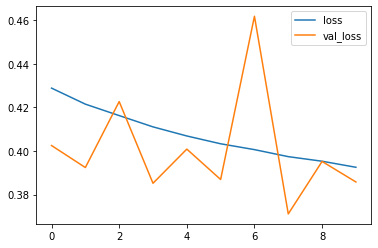

In [70]:
pd.DataFrame(history.history).plot()

In [71]:
model.evaluate([X_test_scaled_A,X_test_scaled_B],[y_test,y_test])

162/162 [==============================] - 0s 2ms/step - loss: 0.3879


0.38794147968292236

In [72]:
model.predict([X_test_scaled_A,X_test_scaled_B])

array([[0.5007378],
       [1.8504199],
       [3.013398 ],
       ...,
       [1.3419657],
       [2.412967 ],
       [3.6620126]], dtype=float32)

![Exercise solution](https://camo.githubusercontent.com/250388fde3fac9135ead9471733ee28e049f7a37/68747470733a2f2f75706c6f61642e77696b696d656469612e6f72672f77696b6970656469612f636f6d6d6f6e732f302f30362f46696c6f735f736567756e646f5f6c6f676f5f253238666c69707065642532392e6a7067)

## Exercise 7 – Solution

### 7.1)
Use Keras' functional API to implement a Wide & Deep network to tackle the California housing problem.

In [ ]:
input = keras.layers.Input(shape=X_train.shape[1:])
hidden1 = keras.layers.Dense(30, activation="relu")(input)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input, hidden2])
output = keras.layers.Dense(1)(concat)

In [ ]:
model = keras.models.Model(inputs=[input], outputs=[output])

In [ ]:
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(1e-3))

In [ ]:
model.summary()

In [ ]:
history = model.fit(X_train_scaled, y_train, epochs=10,
                    validation_data=(X_valid_scaled, y_valid))

In [ ]:
model.evaluate(X_test_scaled, y_test)

In [ ]:
model.predict(X_test_scaled)

### 7.2)
After the Sequential API and the Functional API, let's try the Subclassing API:
* Create a subclass of the `keras.models.Model` class.
* Create all the layers you need in the constructor (e.g., `self.hidden1 = keras.layers.Dense(...)`).
* Use the layers to process the `input` in the `call()` method, and return the output.
* Note that you do not need to create a `keras.layers.Input` in this case.
* Also note that `self.output` is used by Keras, so you should use another name for the output layer (e.g., `self.output_layer`).

In [ ]:
class MyModel(keras.models.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.hidden1 = keras.layers.Dense(30, activation="relu")
        self.hidden2 = keras.layers.Dense(30, activation="relu")
        self.output_ = keras.layers.Dense(1)

    def call(self, input):
        hidden1 = self.hidden1(input)
        hidden2 = self.hidden2(hidden1)
        concat = keras.layers.concatenate([input, hidden2])
        output = self.output_(concat)
        return output

model = MyModel()

In [ ]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(1e-3))

In [ ]:
history = model.fit(X_train_scaled, y_train, epochs=10,
                    validation_data=(X_valid_scaled, y_valid))

In [ ]:
model.summary()

In [ ]:
model.evaluate(X_test_scaled, y_test)

In [ ]:
model.predict(X_test_scaled)

### 7.3)
Now suppose you want to send only features 0 to 4 directly to the output, and only features 2 to 7 through the hidden layers, as shown on the diagram. Use the functional API to build, train and evaluate this model.

In [ ]:
input_A = keras.layers.Input(shape=[5])
input_B = keras.layers.Input(shape=[6])

In [ ]:
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1)(concat)

In [ ]:
model = keras.models.Model(inputs=[input_A, input_B], outputs=[output])

In [ ]:
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(1e-3))

In [ ]:
model.summary()

In [ ]:
X_train_scaled_A = X_train_scaled[:, :5]
X_train_scaled_B = X_train_scaled[:, 2:]
X_valid_scaled_A = X_valid_scaled[:, :5]
X_valid_scaled_B = X_valid_scaled[:, 2:]
X_test_scaled_A = X_test_scaled[:, :5]
X_test_scaled_B = X_test_scaled[:, 2:]

In [ ]:
history = model.fit([X_train_scaled_A, X_train_scaled_B], y_train, epochs=10,
                    validation_data=([X_valid_scaled_A, X_valid_scaled_B], y_valid))

In [ ]:
model.evaluate([X_test_scaled_A, X_test_scaled_B], y_test)

In [ ]:
model.predict([X_test_scaled_A, X_test_scaled_B])

### 7.4)
Build the multi-input and multi-output neural net represented in the diagram.

In [ ]:
input_A = keras.layers.Input(shape=X_train_scaled_A.shape[1:])
input_B = keras.layers.Input(shape=X_train_scaled_B.shape[1:])
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1)(concat)
aux_output = keras.layers.Dense(1)(hidden2)

In [ ]:
model = keras.models.Model(inputs=[input_A, input_B],
                           outputs=[output, aux_output])

In [ ]:
model.compile(loss="mean_squared_error", loss_weights=[0.9, 0.1],
              optimizer=keras.optimizers.SGD(1e-3))

In [ ]:
model.summary()

In [ ]:
history = model.fit([X_train_scaled_A, X_train_scaled_B], [y_train, y_train], epochs=10,
                    validation_data=([X_valid_scaled_A, X_valid_scaled_B], [y_valid, y_valid]))

In [ ]:
model.evaluate([X_test_scaled_A, X_test_scaled_B], [y_test, y_test])

In [ ]:
y_pred, y_pred_aux = model.predict([X_test_scaled_A, X_test_scaled_B])

In [ ]:
y_pred

In [ ]:
y_pred_aux

![Exercise](https://c1.staticflickr.com/9/8101/8553474140_c50cf08708_b.jpg)

## Exercise 8 – Deep Nets

Let's go back to Fashion MNIST and build deep nets to tackle it. We need to load it, split it and scale it.

In [6]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float32).reshape(-1, 28 * 28)).reshape(-1, 28, 28)
X_valid_scaled = scaler.transform(X_valid.astype(np.float32).reshape(-1, 28 * 28)).reshape(-1, 28, 28)
X_test_scaled = scaler.transform(X_test.astype(np.float32).reshape(-1, 28 * 28)).reshape(-1, 28, 28)

### 8.1)
Build a sequential model with 20 hidden dense layers, with 100 neurons each, using the ReLU activation function, plus the output layer (10 neurons, softmax activation function). Try to train it for 10 epochs on Fashion MNIST and plot the learning curves. Notice that progress is very slow.

In [8]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28,28]))
for _ in range(20):
    model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))

model.compile(loss="sparse_categorical_crossentropy",optimizer=keras.optimizers.SGD(1e-3),metrics=["accuracy"])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               78500     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_5 (Dense)              (None, 100)               1

In [17]:
history = model.fit(X_train_scaled, y_train,epochs=10,
                   validation_data=(X_test_scaled,y_test))

Epoch 1/10
1719/1719 [==============================] - 11s 6ms/step - loss: 2.3010 - accuracy: 0.1529 - val_loss: 2.3001 - val_accuracy: 0.1512
Epoch 2/10
1719/1719 [==============================] - 11s 6ms/step - loss: 2.2984 - accuracy: 0.1738 - val_loss: 2.2961 - val_accuracy: 0.2265
Epoch 3/10
1719/1719 [==============================] - 11s 6ms/step - loss: 2.2914 - accuracy: 0.2268 - val_loss: 2.2851 - val_accuracy: 0.2295
Epoch 4/10
1719/1719 [==============================] - 11s 6ms/step - loss: 2.2741 - accuracy: 0.2266 - val_loss: 2.2591 - val_accuracy: 0.2246
Epoch 5/10
1719/1719 [==============================] - 11s 6ms/step - loss: 2.2278 - accuracy: 0.2245 - val_loss: 2.1786 - val_accuracy: 0.2112
Epoch 6/10
1719/1719 [==============================] - 11s 6ms/step - loss: 2.0264 - accuracy: 0.2095 - val_loss: 1.8538 - val_accuracy: 0.2005
Epoch 7/10
1719/1719 [==============================] - 12s 7ms/step - loss: 1.7584 - accuracy: 0.2200 - val_loss: 1.6791 - val_ac

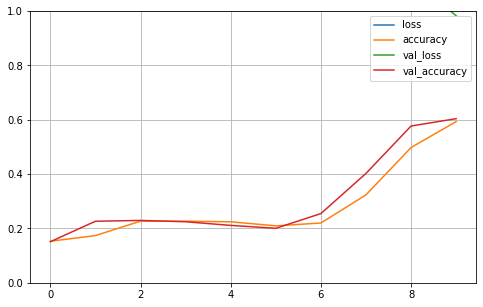

In [18]:
plot_ler_cur(history)

### 8.2)
Update the model to add a `BatchNormalization` layer after every hidden layer. Notice that performance progresses much faster per epoch, although computations are much more intensive. Display the model summary and notice all the non-trainable parameters (the scale $\gamma$ and offset $\beta$ parameters).

In [11]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28,28]))
for _ in range(20):
    model.add(keras.layers.Dense(100, activation="relu"))
    model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(10, activation="softmax"))

model.compile(loss="sparse_categorical_crossentropy",optimizer=keras.optimizers.SGD(1e-3),metrics=["accuracy"])

In [12]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 100)               78500     
_________________________________________________________________
batch_normalization (BatchNo (None, 100)               400       
_________________________________________________________________
dense_22 (Dense)             (None, 100)               10100     
_________________________________________________________________
batch_normalization_1 (Batch (None, 100)               400       
_________________________________________________________________
dense_23 (Dense)             (None, 100)               10100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)              

In [21]:
history = model.fit(X_train_scaled, y_train,epochs=10,
                   validation_data=(X_test_scaled,y_test))

Epoch 1/10
1719/1719 [==============================] - 20s 12ms/step - loss: 1.9520 - accuracy: 0.3593 - val_loss: 1.0765 - val_accuracy: 0.6242
Epoch 2/10
1719/1719 [==============================] - 20s 11ms/step - loss: 1.1023 - accuracy: 0.6199 - val_loss: 0.8233 - val_accuracy: 0.7059
Epoch 3/10
1719/1719 [==============================] - 20s 12ms/step - loss: 0.9708 - accuracy: 0.6614 - val_loss: 0.7337 - val_accuracy: 0.7362
Epoch 4/10
1719/1719 [==============================] - 20s 12ms/step - loss: 0.8898 - accuracy: 0.6879 - val_loss: 0.6841 - val_accuracy: 0.7531
Epoch 5/10
1719/1719 [==============================] - 20s 12ms/step - loss: 0.8400 - accuracy: 0.7050 - val_loss: 0.6512 - val_accuracy: 0.7662
Epoch 6/10
1719/1719 [==============================] - 20s 12ms/step - loss: 0.7963 - accuracy: 0.7217 - val_loss: 0.6180 - val_accuracy: 0.7755
Epoch 7/10
1719/1719 [==============================] - 21s 12ms/step - loss: 0.7637 - accuracy: 0.7345 - val_loss: 0.5947 -

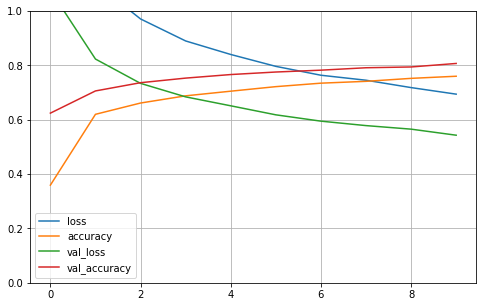

In [22]:
plot_ler_cur(history)

### 8.3)
Try moving the BN layers before the hidden layers' activation functions. Does this affect the model's performance?

In [13]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28,28]))
for _ in range(20):
    model.add(keras.layers.Dense(100))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation("relu"))
model.add(keras.layers.Dense(10, activation="softmax"))

model.compile(loss="sparse_categorical_crossentropy",optimizer=keras.optimizers.SGD(1e-3),metrics=["accuracy"])

In [14]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_42 (Dense)             (None, 100)               78500     
_________________________________________________________________
batch_normalization_20 (Batc (None, 100)               400       
_________________________________________________________________
activation (Activation)      (None, 100)               0         
_________________________________________________________________
dense_43 (Dense)             (None, 100)               10100     
_________________________________________________________________
batch_normalization_21 (Batc (None, 100)               400       
_________________________________________________________________
activation_1 (Activation)    (None, 100)              

In [24]:
history = model.fit(X_train_scaled, y_train,epochs=10,
                   validation_data=(X_test_scaled,y_test))

Epoch 1/10
1719/1719 [==============================] - 20s 12ms/step - loss: 2.1025 - accuracy: 0.2702 - val_loss: 1.3183 - val_accuracy: 0.5556
Epoch 2/10
1719/1719 [==============================] - 20s 11ms/step - loss: 1.2194 - accuracy: 0.5883 - val_loss: 0.8696 - val_accuracy: 0.6971
Epoch 3/10
1719/1719 [==============================] - 20s 11ms/step - loss: 0.9793 - accuracy: 0.6627 - val_loss: 0.7381 - val_accuracy: 0.7355
Epoch 4/10
1719/1719 [==============================] - 20s 12ms/step - loss: 0.8832 - accuracy: 0.6969 - val_loss: 0.6750 - val_accuracy: 0.7543
Epoch 5/10
1719/1719 [==============================] - 20s 12ms/step - loss: 0.8234 - accuracy: 0.7181 - val_loss: 0.6273 - val_accuracy: 0.7737
Epoch 6/10
1719/1719 [==============================] - 20s 12ms/step - loss: 0.7652 - accuracy: 0.7363 - val_loss: 0.5843 - val_accuracy: 0.7943
Epoch 7/10
1719/1719 [==============================] - 20s 12ms/step - loss: 0.7280 - accuracy: 0.7500 - val_loss: 0.5627 -

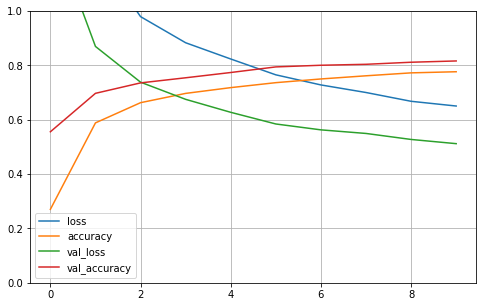

In [25]:
plot_ler_cur(history)

### 8.4)
Remove all the BN layers, and just use the SELU activation function instead (always use SELU with LeCun Normal weight initialization). Notice that you get better performance than with BN but training is much faster. Isn't it marvelous? :-)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_8 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_148 (Dense)            (None, 100)               78500     
_________________________________________________________________
dense_149 (Dense)            (None, 100)               10100     
_________________________________________________________________
dense_150 (Dense)            (None, 100)               10100     
_________________________________________________________________
dense_151 (Dense)            (None, 100)               10100     
_________________________________________________________________
dense_152 (Dense)            (None, 100)               10100     
_________________________________________________________________
dense_153 (Dense)            (None, 100)              

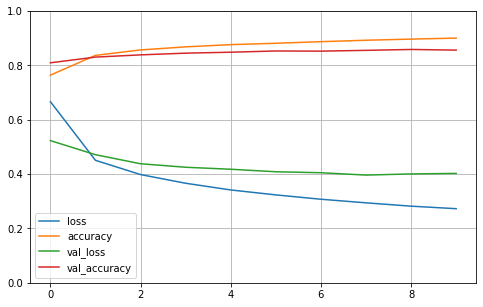

In [22]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28,28]))
for _ in range(20):
    model.add(keras.layers.Dense(100,activation="selu",kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

model.compile(loss="sparse_categorical_crossentropy",optimizer=keras.optimizers.SGD(1e-3),metrics=["accuracy"])

model.summary()

history = model.fit(X_train_scaled, y_train,epochs=10,
                   validation_data=(X_test_scaled,y_test))

plot_ler_cur(history)

In [24]:
model.evaluate(X_test_scaled,y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.4025 - accuracy: 0.8561


[0.4024650454521179, 0.8561000227928162]

### 8.5)
Try training for 10 additional epochs, and notice that the model starts overfitting. Try adding a Dropout layer (with a 50% dropout rate) just before the output layer. Does it reduce overfitting? What about the final validation accuracy?

**Warning**: you should not use regular Dropout, as it breaks the self-normalizing property of the SELU activation function. Instead, use AlphaDropout, which is designed to work with SELU.

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_9 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_169 (Dense)            (None, 100)               78500     
_________________________________________________________________
dense_170 (Dense)            (None, 100)               10100     
_________________________________________________________________
dense_171 (Dense)            (None, 100)               10100     
_________________________________________________________________
dense_172 (Dense)            (None, 100)               10100     
_________________________________________________________________
dense_173 (Dense)            (None, 100)               10100     
_________________________________________________________________
dense_174 (Dense)            (None, 100)              

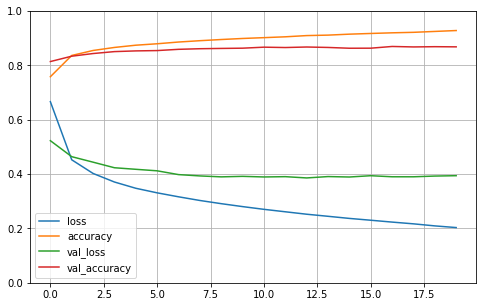

In [25]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28,28]))
for _ in range(20):
    model.add(keras.layers.Dense(100,activation="selu",kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

model.compile(loss="sparse_categorical_crossentropy",optimizer=keras.optimizers.SGD(1e-3),metrics=["accuracy"])

model.summary()

history = model.fit(X_train_scaled, y_train,epochs=20,
                   validation_data=(X_test_scaled,y_test))

plot_ler_cur(history)

In [26]:
model.evaluate(X_test_scaled,y_test)

313/313 [==============================] - 1s 4ms/step - loss: 0.3941 - accuracy: 0.8681


[0.3940516710281372, 0.8680999875068665]

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_11 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_210 (Dense)            (None, 100)               78500     
_________________________________________________________________
dense_211 (Dense)            (None, 100)               10100     
_________________________________________________________________
dense_212 (Dense)            (None, 100)               10100     
_________________________________________________________________
dense_213 (Dense)            (None, 100)               10100     
_________________________________________________________________
dense_214 (Dense)            (None, 100)               10100     
_________________________________________________________________
dense_215 (Dense)            (None, 100)             

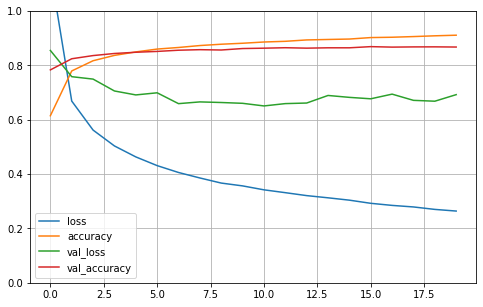

In [28]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28,28]))
for _ in range(20):
    model.add(keras.layers.Dense(100,activation="selu",kernel_initializer="lecun_normal"))
model.add(keras.layers.AlphaDropout(rate=0.5))
model.add(keras.layers.Dense(10, activation="softmax"))

model.compile(loss="sparse_categorical_crossentropy",optimizer=keras.optimizers.SGD(1e-3),metrics=["accuracy"])

model.summary()

history = model.fit(X_train_scaled, y_train,epochs=20,
                   validation_data=(X_test_scaled,y_test))

plot_ler_cur(history)

In [29]:
model.evaluate(X_test_scaled,y_test)

313/313 [==============================] - 1s 4ms/step - loss: 0.6923 - accuracy: 0.8674


[0.6922650337219238, 0.8673999905586243]

![Exercise solution](https://camo.githubusercontent.com/250388fde3fac9135ead9471733ee28e049f7a37/68747470733a2f2f75706c6f61642e77696b696d656469612e6f72672f77696b6970656469612f636f6d6d6f6e732f302f30362f46696c6f735f736567756e646f5f6c6f676f5f253238666c69707065642532392e6a7067)

## Exercise 8 – Solution

### 8.1)
Build a sequential model with 20 hidden dense layers, with 100 neurons each, using the ReLU activation function, plus the output layer (10 neurons, softmax activation function). Try to train it for 10 epochs on Fashion MNIST and plot the learning curves. Notice that progress is very slow.

Epoch 1/10
1719/1719 [==============================] - 11s 6ms/step - loss: 2.3018 - accuracy: 0.1509 - val_loss: 2.3007 - val_accuracy: 0.2418
Epoch 2/10
1719/1719 [==============================] - 10s 6ms/step - loss: 2.2991 - accuracy: 0.2433 - val_loss: 2.2969 - val_accuracy: 0.2270
Epoch 3/10
1719/1719 [==============================] - 10s 6ms/step - loss: 2.2931 - accuracy: 0.2450 - val_loss: 2.2879 - val_accuracy: 0.2664
Epoch 4/10
1719/1719 [==============================] - 11s 6ms/step - loss: 2.2790 - accuracy: 0.2307 - val_loss: 2.2661 - val_accuracy: 0.2362
Epoch 5/10
1719/1719 [==============================] - 10s 6ms/step - loss: 2.2417 - accuracy: 0.2022 - val_loss: 2.2054 - val_accuracy: 0.1756
Epoch 6/10
1719/1719 [==============================] - 10s 6ms/step - loss: 2.1224 - accuracy: 0.1937 - val_loss: 1.9946 - val_accuracy: 0.1854
Epoch 7/10
1719/1719 [==============================] - 11s 7ms/step - loss: 1.8114 - accuracy: 0.2145 - val_loss: 1.6818 - val_ac

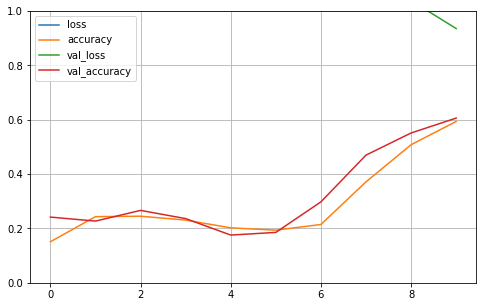

In [20]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
for _ in range(20):
    model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))
model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.SGD(1e-3),
              metrics=["accuracy"])
history = model.fit(X_train_scaled, y_train, epochs=10,
                    validation_data=(X_valid_scaled, y_valid))
plot_ler_cur(history)

### 8.2)
Update the model to add a `BatchNormalization` layer after every hidden layer. Notice that performance progresses much faster per epoch, although computations are much more intensive. Display the model summary and notice all the non-trainable parameters (the scale $\gamma$ and offset $\beta$ parameters).

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
for _ in range(20):
    model.add(keras.layers.Dense(100, activation="relu"))
    model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(10, activation="softmax"))
model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.SGD(1e-3),
              metrics=["accuracy"])
history = model.fit(X_train_scaled, y_train, epochs=10,
                    validation_data=(X_valid_scaled, y_valid))
plot_learning_curves(history)

In [ ]:
model.summary()

### 8.3)
Try moving the BN layers before the hidden layers' activation functions. Does this affect the model's performance?

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
for _ in range(20):
    model.add(keras.layers.Dense(100))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation("relu"))
model.add(keras.layers.Dense(10, activation="softmax"))
model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.SGD(1e-3),
              metrics=["accuracy"])
history = model.fit(X_train_scaled, y_train, epochs=10,
                    validation_data=(X_valid_scaled, y_valid))
plot_learning_curves(history)

### 8.4)
Remove all the BN layers, and just use the SELU activation function instead (always use SELU with LeCun Normal weight initialization). Notice that you get better performance than with BN but training is much faster. Isn't it marvelous? :-)

Epoch 1/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.6741 - accuracy: 0.7608 - val_loss: 0.4944 - val_accuracy: 0.8250
Epoch 2/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.4632 - accuracy: 0.8323 - val_loss: 0.4329 - val_accuracy: 0.8452
Epoch 3/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.4126 - accuracy: 0.8501 - val_loss: 0.4047 - val_accuracy: 0.8518
Epoch 4/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.3805 - accuracy: 0.8617 - val_loss: 0.3825 - val_accuracy: 0.8618
Epoch 5/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.3569 - accuracy: 0.8698 - val_loss: 0.3854 - val_accuracy: 0.8626
Epoch 6/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.3380 - accuracy: 0.8764 - val_loss: 0.3762 - val_accuracy: 0.8640
Epoch 7/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.3226 - accuracy: 0.8820 - val_loss: 0.3607 - val_ac

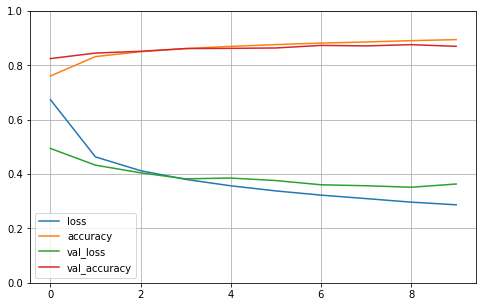

In [21]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
for _ in range(20):
    model.add(keras.layers.Dense(100, activation="selu",
                                 kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))
model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.SGD(1e-3),
              metrics=["accuracy"])
history = model.fit(X_train_scaled, y_train, epochs=10,
                    validation_data=(X_valid_scaled, y_valid))
plot_ler_cur(history)

### 8.5)
Try training for 10 additional epochs, and notice that the model starts overfitting. Try adding a Dropout layer (with a 50% dropout rate) just before the output layer. Does it reduce overfitting? What about the final validation accuracy?

In [ ]:
history = model.fit(X_train_scaled, y_train, epochs=10,
                    validation_data=(X_valid_scaled, y_valid))
plot_learning_curves(history)

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
for _ in range(20):
    model.add(keras.layers.Dense(100, activation="selu",
                                 kernel_initializer="lecun_normal"))
model.add(keras.layers.AlphaDropout(rate=0.5))
model.add(keras.layers.Dense(10, activation="softmax"))
model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.SGD(1e-3),
              metrics=["accuracy"])
history = model.fit(X_train_scaled, y_train, epochs=20,
                    validation_data=(X_valid_scaled, y_valid))
plot_learning_curves(history)